# Main Example Trading Model Analysis

This notebook replicates the analysis from `main_example.py` with enhanced visualizations and detailed performance metrics.

## Setup and Configuration

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

if "FRED_API_KEY" not in os.environ:
    raise RuntimeError("FRED_API_KEY environment variable is required. Create a .env file or export the variable before running this notebook.")

print("✅ Environment ready. FRED_API_KEY detected.")

🎯 Using custom threshold: 0.9
📊 Label horizon: 70 days


## Data Loading and Feature Engineering

In [15]:
# Fetch and prepare data
print("📈 Fetching S&P 500 data from FRED...")
df = fetch_sp500_from_fred(start="2000-01-01")
print(f"   Raw data shape: {df.shape}")
print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")

print("\n🔧 Building feature set...")
df_feat = build_feature_set(df)
print(f"   Features shape: {df_feat.shape}")

print("\n🏷️ Creating labels...")
df_lab = make_std_labels(df_feat, horizon=LABEL_HORIZON)
print(f"   Final dataset shape: {df_lab.shape}")

# Define feature columns (exclude non-feature columns)
exclude = {"Date", "Close", "label", "fwd_return", "vol_h"}
feature_cols = [c for c in df_lab.columns if c not in exclude]
print(f"\n📊 Feature columns ({len(feature_cols)}): {feature_cols[:5]}...")

# Display basic statistics
df_clean = df_lab.dropna(subset=feature_cols + ["label"])
print(f"\n📋 Clean dataset info:")
print(f"   Rows after cleaning: {len(df_clean)}")
print(f"   Label distribution: {dict(zip(*np.unique(df_clean['label'], return_counts=True)))}")

📈 Fetching S&P 500 data from FRED...
   Raw data shape: (2515, 2)
   Date range: 2015-09-21 00:00:00 to 2025-09-19 00:00:00

🔧 Building feature set...
   Raw data shape: (2515, 2)
   Date range: 2015-09-21 00:00:00 to 2025-09-19 00:00:00

🔧 Building feature set...
   Features shape: (2515, 15)

🏷️ Creating labels...
   Final dataset shape: (2515, 18)

📊 Feature columns (13): ['SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg']...

📋 Clean dataset info:
   Rows after cleaning: 1533
   Label distribution: {np.float64(0.0): np.int64(1229), np.float64(1.0): np.int64(304)}
   Features shape: (2515, 15)

🏷️ Creating labels...
   Final dataset shape: (2515, 18)

📊 Feature columns (13): ['SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg']...

📋 Clean dataset info:
   Rows after cleaning: 1533
   Label distribution: {np.float64(0.0): np.int64(1229), np.float64(1.0): np.int64(304)}


## Rolling Window Training and Prediction

In [16]:
# Perform rolling window training with custom threshold
print(f"🤖 Running rolling window training with threshold {CUSTOM_THRESHOLD}...")
df_pred = rolling_train_predict(df_lab, feature_cols=feature_cols, decision_threshold=CUSTOM_THRESHOLD)

# Analyze predictions
pred_data = df_pred.dropna(subset=["pred", "label"])
print(f"\n📊 Prediction Results:")
print(f"   Total predictions: {len(pred_data)}")
print(f"   Prediction distribution: {dict(zip(*np.unique(pred_data['pred'], return_counts=True)))}")
print(f"   Label distribution: {dict(zip(*np.unique(pred_data['label'], return_counts=True)))}")

if len(pred_data) > 0:
    accuracy = (pred_data["pred"] == pred_data["label"]).mean()
    print(f"   Overall Accuracy: {accuracy:.3f}")
    
    # Confusion matrix components
    tp = ((pred_data["label"] == 1) & (pred_data["pred"] == 1)).sum()
    tn = ((pred_data["label"] == 0) & (pred_data["pred"] == 0)).sum()
    fp = ((pred_data["label"] == 0) & (pred_data["pred"] == 1)).sum()
    fn = ((pred_data["label"] == 1) & (pred_data["pred"] == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"   Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print(f"   Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

🤖 Running rolling window training with threshold 0.9...

📊 Prediction Results:
   Total predictions: 1125
   Prediction distribution: {np.float64(0.0): np.int64(1097), np.float64(1.0): np.int64(28)}
   Label distribution: {np.float64(0.0): np.int64(903), np.float64(1.0): np.int64(222)}
   Overall Accuracy: 0.806
   Confusion Matrix: TP=16, TN=891, FP=12, FN=206
   Precision: 0.571, Recall: 0.072, F1: 0.128

📊 Prediction Results:
   Total predictions: 1125
   Prediction distribution: {np.float64(0.0): np.int64(1097), np.float64(1.0): np.int64(28)}
   Label distribution: {np.float64(0.0): np.int64(903), np.float64(1.0): np.int64(222)}
   Overall Accuracy: 0.806
   Confusion Matrix: TP=16, TN=891, FP=12, FN=206
   Precision: 0.571, Recall: 0.072, F1: 0.128


## Backtest Analysis

In [17]:
# Run backtest on six windows
print("🔄 Running backtest on six windows...")
win_results, report_df = backtest_six_windows(
    df_lab.dropna(subset=feature_cols + ["label"]), 
    feature_cols=feature_cols, 
    decision_threshold=CUSTOM_THRESHOLD
)

print("\n📋 Backtest Report (per window):")
print(report_df)

# Detailed analysis of first window if available
if len(win_results) > 0:
    sample = win_results[0].dropna(subset=["label", "pred"])
    if len(sample) > 0:
        tp, tn, fp, fn = confusion_counts(sample["label"].values, sample["pred"].values)
        precision, recall, f1 = precision_recall_f1(tp, tn, fp, fn)
        print(f"\n🔍 First Window Detailed Metrics:")
        print(f"   TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        print(f"   Precision(class 1)={precision:.3f}, Recall(class 1)={recall:.3f}, F1(class 1)={f1:.3f}")

🔄 Running backtest on six windows...

📋 Backtest Report (per window):
  window_start  window_end  TP  TN  FP  FN  precision_1  recall_1    f1_1   n
0   2024-06-10  2024-08-10   5  31   0   7          1.0    0.4167  0.5882  43
1   2024-08-10  2024-10-10   0  19   0  23          0.0    0.0000  0.0000  42
2   2024-10-10  2024-12-10   3  32   7   0          0.3    1.0000  0.4615  42
3   2024-12-10  2025-02-10   0  40   0   0          0.0    0.0000  0.0000  40
4   2025-02-10  2025-04-10   0  21   0  21          0.0    0.0000  0.0000  42
5   2025-04-10  2025-06-10   0  13   0  28          0.0    0.0000  0.0000  41

🔍 First Window Detailed Metrics:
   TP=5, TN=31, FP=0, FN=7
   Precision(class 1)=1.000, Recall(class 1)=0.417, F1(class 1)=0.588

📋 Backtest Report (per window):
  window_start  window_end  TP  TN  FP  FN  precision_1  recall_1    f1_1   n
0   2024-06-10  2024-08-10   5  31   0   7          1.0    0.4167  0.5882  43
1   2024-08-10  2024-10-10   0  19   0  23          0.0    0.000

## Equity Curve Analysis

In [18]:
# Calculate equity curves with improved implementation
print("💰 Calculating equity curves...")
trading_data = df_pred.dropna(subset=["pred"])

def fixed_equity_curve_algorithm(df, monthly_day=25, contribution=1000.0, price_col="Close"):
    """
    Fixed algorithm equity curve: Buy only when model predicts 1
    """
    df = df.copy().dropna(subset=[price_col]).reset_index(drop=True)
    
    cash = 0.0
    units = 0.0
    pending_cash = 0.0
    last_contribution_month = None
    
    results = []
    
    for i, row in df.iterrows():
        date = pd.to_datetime(row["Date"])
        price = row[price_col]
        
        # Add monthly contribution on the 25th (or first trading day after)
        current_month = (date.year, date.month)
        if current_month != last_contribution_month and date.day >= monthly_day:
            pending_cash += contribution
            last_contribution_month = current_month
        
        # Buy if model predicts 1 and we have pending cash
        if row.get("pred", 0) == 1 and pending_cash > 0:
            new_units = pending_cash / price
            units += new_units
            cash += pending_cash  # Track total cash invested
            pending_cash = 0.0
        
        equity = units * price + pending_cash  # Equity = shares value + uninvested cash
        
        results.append({
            'Date': row['Date'],
            'cash': cash,
            'units': units,
            'pending_cash': pending_cash,
            'equity': equity
        })
    
    return pd.DataFrame(results)

def fixed_equity_curve_dca(df, monthly_day=25, contribution=1000.0, price_col="Close"):
    """
    Fixed DCA baseline: Buy every month on the 25th
    """
    df = df.copy().dropna(subset=[price_col]).reset_index(drop=True)
    
    cash_invested = 0.0
    units = 0.0
    last_contribution_month = None
    
    results = []
    
    for i, row in df.iterrows():
        date = pd.to_datetime(row["Date"])
        price = row[price_col]
        
        # Add monthly contribution and buy immediately on the 25th (or first trading day after)
        current_month = (date.year, date.month)
        if current_month != last_contribution_month and date.day >= monthly_day:
            new_units = contribution / price
            units += new_units
            cash_invested += contribution
            last_contribution_month = current_month
        
        equity = units * price
        
        results.append({
            'Date': row['Date'],
            'cash': cash_invested,
            'units': units,
            'equity': equity
        })
    
    return pd.DataFrame(results)

if len(trading_data) > 0:
    # Calculate both equity curves with fixed functions
    print("   Calculating algorithm equity curve...")
    dca_df = fixed_equity_curve_algorithm(trading_data)
    
    print("   Calculating DCA baseline equity curve...")
    baseline_df = fixed_equity_curve_dca(trading_data)
    
    print(f"\n📊 Algorithm Equity (first 5 rows):")
    print(dca_df[["Date", "cash", "units", "equity"]].head())
    print(f"\n📊 Algorithm Equity (last 5 rows):")
    print(dca_df[["Date", "cash", "units", "equity"]].tail())
    
    print(f"\n📊 DCA Baseline Equity (first 5 rows):")
    print(baseline_df[["Date", "cash", "units", "equity"]].head())
    print(f"\n📊 DCA Baseline Equity (last 5 rows):")
    print(baseline_df[["Date", "cash", "units", "equity"]].tail())
    
    # Performance comparison
    final_algo_equity = dca_df["equity"].iloc[-1]
    final_dca_equity = baseline_df["equity"].iloc[-1]
    
    print(f"\n💡 Performance Comparison:")
    print(f"   Algorithm final equity: ${final_algo_equity:,.2f}")
    print(f"   DCA Baseline final equity: ${final_dca_equity:,.2f}")
    print(f"   Difference: ${final_algo_equity - final_dca_equity:,.2f} ({((final_algo_equity / final_dca_equity - 1) * 100):+.2f}%)")
    
    # Store for visualization
    algo_equity = final_algo_equity
    baseline_equity = final_dca_equity
    
    # Additional debugging info
    algo_purchases = (dca_df['units'].diff() > 0).sum()
    dca_purchases = (baseline_df['units'].diff() > 0).sum()
    print(f"\n🔍 Trading Activity:")
    print(f"   Algorithm purchases: {algo_purchases}")
    print(f"   DCA purchases: {dca_purchases}")
    print(f"   Algorithm buy signals: {(trading_data['pred'] == 1).sum()}")
    
else:
    print("❌ No trading data available for equity curve calculation")

💰 Calculating equity curves...
   Calculating algorithm equity curve...
   Calculating DCA baseline equity curve...

📊 Algorithm Equity (first 5 rows):
        Date  cash  units  equity
0 2020-12-16   0.0    0.0     0.0
1 2020-12-17   0.0    0.0     0.0
2 2020-12-18   0.0    0.0     0.0
3 2020-12-21   0.0    0.0     0.0
4 2020-12-22   0.0    0.0     0.0

📊 Algorithm Equity (last 5 rows):
           Date     cash     units        equity
1190 2025-09-15  52000.0  9.748601  69489.726828
1191 2025-09-16  52000.0  9.748601  69406.668745
1192 2025-09-17  52000.0  9.748601  69344.180211
1193 2025-09-18  52000.0  9.748601  69652.333496
1194 2025-09-19  52000.0  9.748601  69968.188176

📊 DCA Baseline Equity (first 5 rows):
        Date  cash  units  equity
0 2020-12-16   0.0    0.0     0.0
1 2020-12-17   0.0    0.0     0.0
2 2020-12-18   0.0    0.0     0.0
3 2020-12-21   0.0    0.0     0.0
4 2020-12-22   0.0    0.0     0.0

📊 DCA Baseline Equity (last 5 rows):
           Date     cash      unit

## Visualization: Equity Curves Comparison

🎯 CREATING SEPARATED TRAINING/TESTING VISUALIZATIONS
📈 Figure A: Training Equity Curves


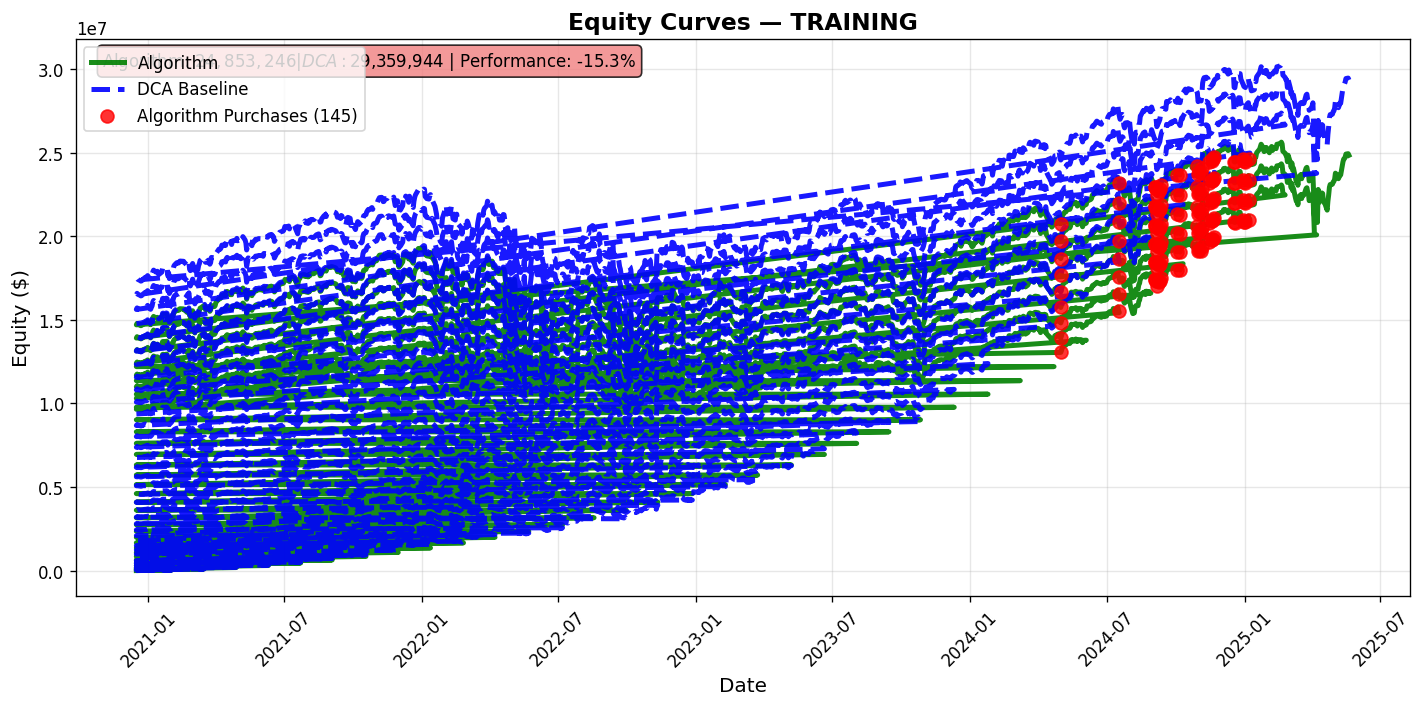

📈 Figure B: Testing Equity Curves


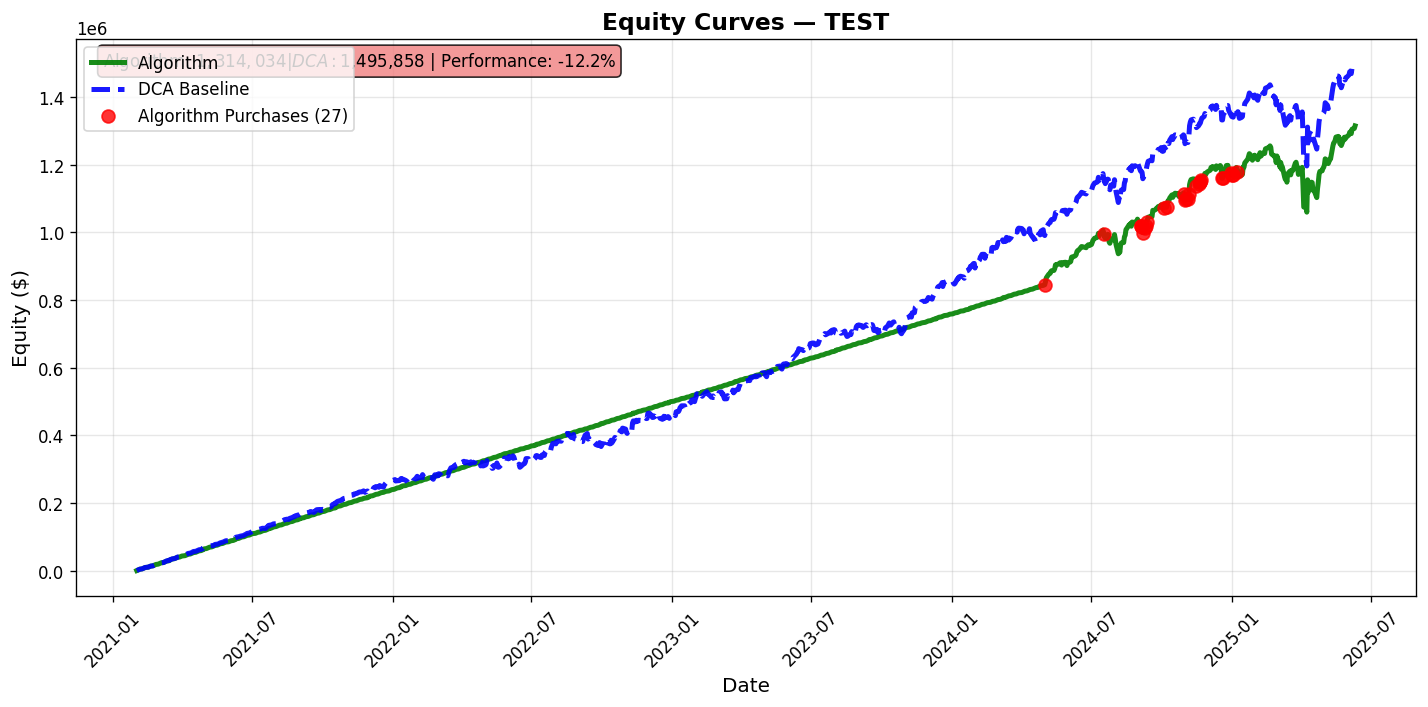

📈 Figure C: Training Signals & Price


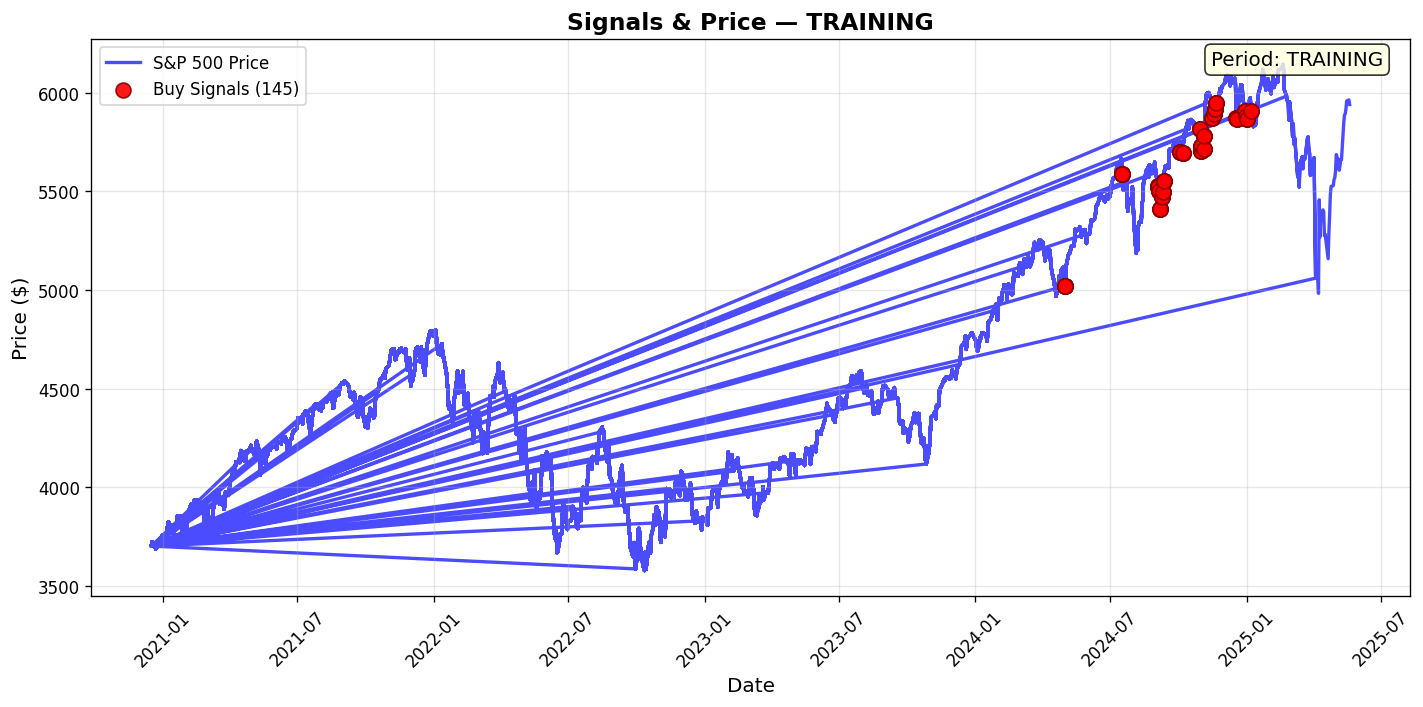

📈 Figure D: Testing Signals & Price


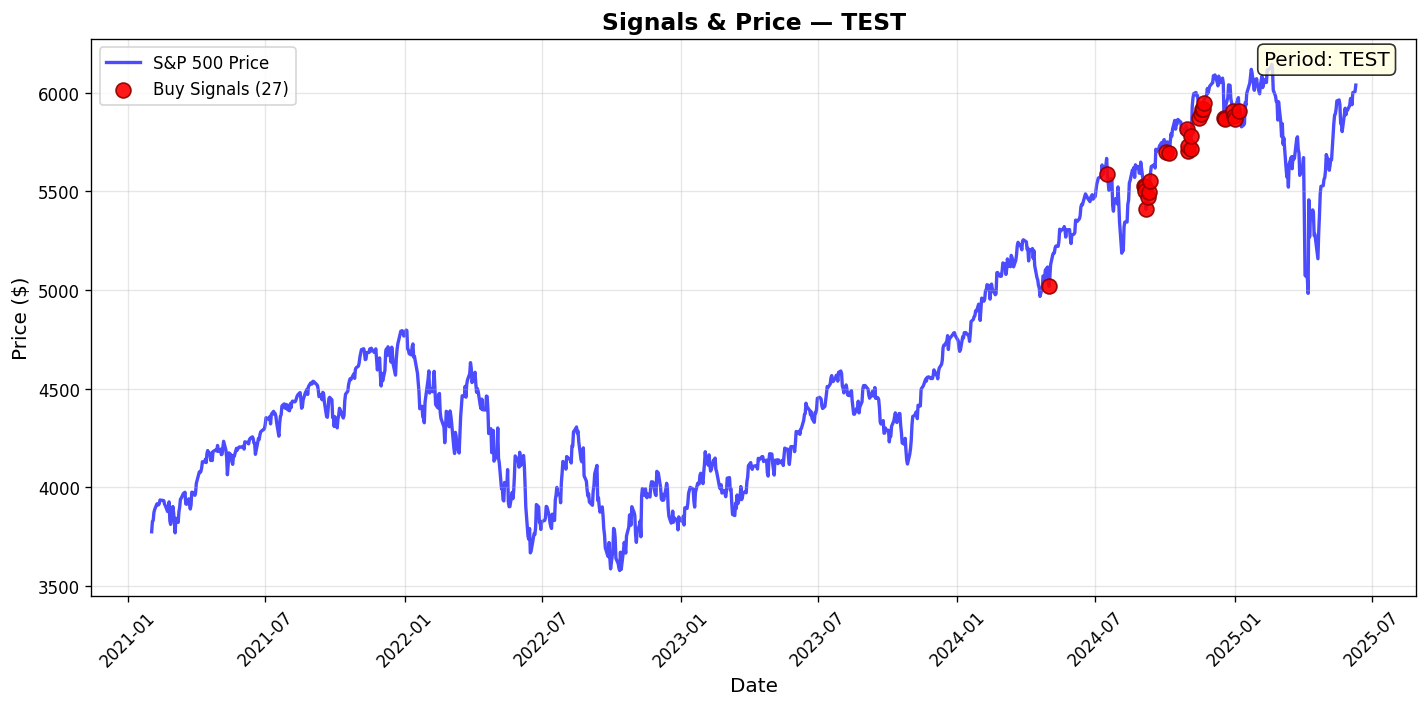


✅ All four separated figures created successfully!
   - equity_training.png: Training period equity curves
   - equity_test.png: Testing period equity curves
   - signals_training.png: Training period price & signals
   - signals_test.png: Testing period price & signals


In [19]:
# Helper functions for separated training/testing visualizations
plot_config = dict(figsize=(12, 6), tight_layout=True, dpi=120)

def plot_equity_curves(df_equity, title, save_path=None):
    """Plot algorithm vs DCA equity curves with performance metrics"""
    fig, ax = plt.subplots(1, 1, **plot_config)
    
    # Convert dates and extract data
    dates = pd.to_datetime(df_equity["Date"])
    algo_equity_vals = df_equity["equity"]
    dca_equity_vals = df_equity["dca_equity"] if "dca_equity" in df_equity.columns else df_equity["equity"]
    
    # Plot equity curves
    ax.plot(dates, algo_equity_vals, 'g-', linewidth=3, 
            label='Algorithm', alpha=0.9)
    ax.plot(dates, dca_equity_vals, 'b--', linewidth=3, 
            label='DCA Baseline', alpha=0.9)
    
    # Mark algorithm purchases
    buy_mask = df_equity['pred'] == 1 if 'pred' in df_equity.columns else df_equity['units'].diff() > 0
    buy_points = df_equity[buy_mask]
    if len(buy_points) > 0:
        buy_dates = pd.to_datetime(buy_points["Date"])
        buy_equity = buy_points["equity"]
        ax.scatter(buy_dates, buy_equity, color='red', s=60, marker='o', 
                   label=f'Algorithm Purchases ({len(buy_points)})', alpha=0.8, zorder=5)
    
    # Calculate performance metrics
    final_algo = algo_equity_vals.iloc[-1]
    final_dca = dca_equity_vals.iloc[-1]
    performance_pct = ((final_algo / final_dca - 1) * 100)
    
    # Add performance annotation
    perf_color = 'lightgreen' if performance_pct > 0 else 'lightcoral'
    legend_text = f'Algorithm: ${final_algo:,.0f} | DCA: ${final_dca:,.0f} | Performance: {performance_pct:+.1f}%'
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Equity ($)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add performance text box
    ax.text(0.02, 0.98, legend_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor=perf_color, alpha=0.8))
    
    if plot_config['tight_layout']:
        plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=plot_config['dpi'], bbox_inches='tight')
    plt.show()

def plot_price_and_signals(df_prices, buys_idx, labels_series, period_label, save_path=None):
    """Plot S&P 500 price with trading signals for a specific period"""
    fig, ax = plt.subplots(1, 1, **plot_config)
    
    # Convert dates and extract data
    dates = pd.to_datetime(df_prices["Date"])
    prices = df_prices["Close"]
    
    # Plot S&P 500 price
    ax.plot(dates, prices, 'b-', linewidth=2, alpha=0.7, 
            label='S&P 500 Price', zorder=1)
    
    # Mark buy signals
    if len(buys_idx) > 0:
        buy_dates = pd.to_datetime(df_prices.iloc[buys_idx]["Date"])
        buy_prices = df_prices.iloc[buys_idx]["Close"]
        ax.scatter(buy_dates, buy_prices, color='red', s=80, marker='o', 
                   label=f'Buy Signals ({len(buys_idx)})', alpha=0.9, zorder=5, edgecolors='darkred')
    
    # Add period label
    ax.text(0.98, 0.98, f'Period: {period_label}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    ax.set_title(f'Signals & Price — {period_label}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    if plot_config['tight_layout']:
        plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=plot_config['dpi'], bbox_inches='tight')
    plt.show()

# Create separated training/testing visualizations
if 'training_equity' in locals() and 'testing_equity' in locals():
    print("🎯 CREATING SEPARATED TRAINING/TESTING VISUALIZATIONS")
    print("=" * 55)
    
    # Figure A: Training equity curves
    print("📈 Figure A: Training Equity Curves")
    plot_equity_curves(training_equity, "Equity Curves — TRAINING", "equity_training.png")
    
    # Figure B: Testing equity curves
    print("📈 Figure B: Testing Equity Curves")
    plot_equity_curves(testing_equity, "Equity Curves — TEST", "equity_test.png")
    
    # Figure C: Training signals and price
    print("📈 Figure C: Training Signals & Price")
    train_buys = training_equity[training_equity['pred'] == 1].index.tolist()
    plot_price_and_signals(training_equity, train_buys, None, "TRAINING", "signals_training.png")
    
    # Figure D: Testing signals and price
    print("📈 Figure D: Testing Signals & Price")
    test_buys = testing_equity[testing_equity['pred'] == 1].index.tolist()
    plot_price_and_signals(testing_equity, test_buys, None, "TEST", "signals_test.png")
    
    print("\n✅ All four separated figures created successfully!")
    print("   - equity_training.png: Training period equity curves")
    print("   - equity_test.png: Testing period equity curves") 
    print("   - signals_training.png: Training period price & signals")
    print("   - signals_test.png: Testing period price & signals")

elif 'dca_df' in locals() and 'baseline_df' in locals() and len(dca_df) > 0 and len(baseline_df) > 0:
    print("⚠️ Using fallback visualization - separated data not available")
    print("📈 Creating combined equity curves visualization...")
    
    # Fallback to original combined visualization
    fig, ax = plt.subplots(1, 1, **plot_config)
    
    # Convert dates to datetime for plotting
    algo_dates = pd.to_datetime(dca_df["Date"])
    baseline_dates = pd.to_datetime(baseline_df["Date"])
    
    # Main equity curves plot
    ax.plot(algo_dates, dca_df["equity"], 'g-', linewidth=3, 
            label=f'Algorithm (Threshold: {CUSTOM_THRESHOLD})', alpha=0.9)
    ax.plot(baseline_dates, baseline_df["equity"], 'b--', linewidth=3, 
            label='DCA Baseline', alpha=0.9)
    
    # Mark buy points for algorithm
    buy_points = dca_df[dca_df['units'].diff() > 0]
    if len(buy_points) > 0:
        buy_dates = pd.to_datetime(buy_points["Date"])
        buy_equity = buy_points["equity"]
        ax.scatter(buy_dates, buy_equity, color='red', s=60, marker='o', 
                   label=f'Algorithm Purchases ({len(buy_points)})', alpha=0.8, zorder=5)
    
    # Calculate and display performance
    performance_pct = ((algo_equity / baseline_equity - 1) * 100)
    perf_color = 'lightgreen' if performance_pct > 0 else 'lightcoral'
    
    ax.text(0.02, 0.98, f'Algorithm: ${algo_equity:,.0f} | DCA: ${baseline_equity:,.0f} | Performance: {performance_pct:+.1f}%', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=perf_color, alpha=0.8))
    
    ax.set_title(f'Equity Curves Comparison - Algorithm vs DCA Baseline\n(Threshold: {CUSTOM_THRESHOLD})', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Equity ($)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional analysis
    print(f"\n📈 EQUITY CURVE ANALYSIS:")
    print(f"   Algorithm final units: {dca_df['units'].iloc[-1]:.2f}")
    print(f"   DCA final units: {baseline_df['units'].iloc[-1]:.2f}")
    
    if len(buy_points) > 0:
        avg_purchase_price = dca_df['cash'].iloc[-1] / dca_df['units'].iloc[-1] if dca_df['units'].iloc[-1] > 0 else 0
        final_price = dca_df["Close"].iloc[-1] if "Close" in dca_df.columns else trading_data["Close"].iloc[-1]
        print(f"   Algorithm avg purchase price: ${avg_purchase_price:.2f}")
        print(f"   Final S&P 500 price: ${final_price:.2f}")
        
    print(f"\\n✅ Improved equity curves plotted with {len(dca_df)} data points!")
else:
    print("❌ No equity data available for plotting")

## Visualization: S&P 500 Price with Trading Signals

📈 Creating S&P 500 visualization with trading signals (Threshold: 0.9)...
   True Positives: 16
   False Positives: 12
   True Negatives: 891
   False Negatives: 206


C:\Users\adisw\AppData\Local\Temp\ipykernel_31104\1925276881.py:63: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adisw\AppData\Local\Temp\ipykernel_31104\1925276881.py:63: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\adisw\Downloads\lab_project_with_solutions\project_solutions\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adisw\Downloads\lab_project_with_solutions\project_solutions\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


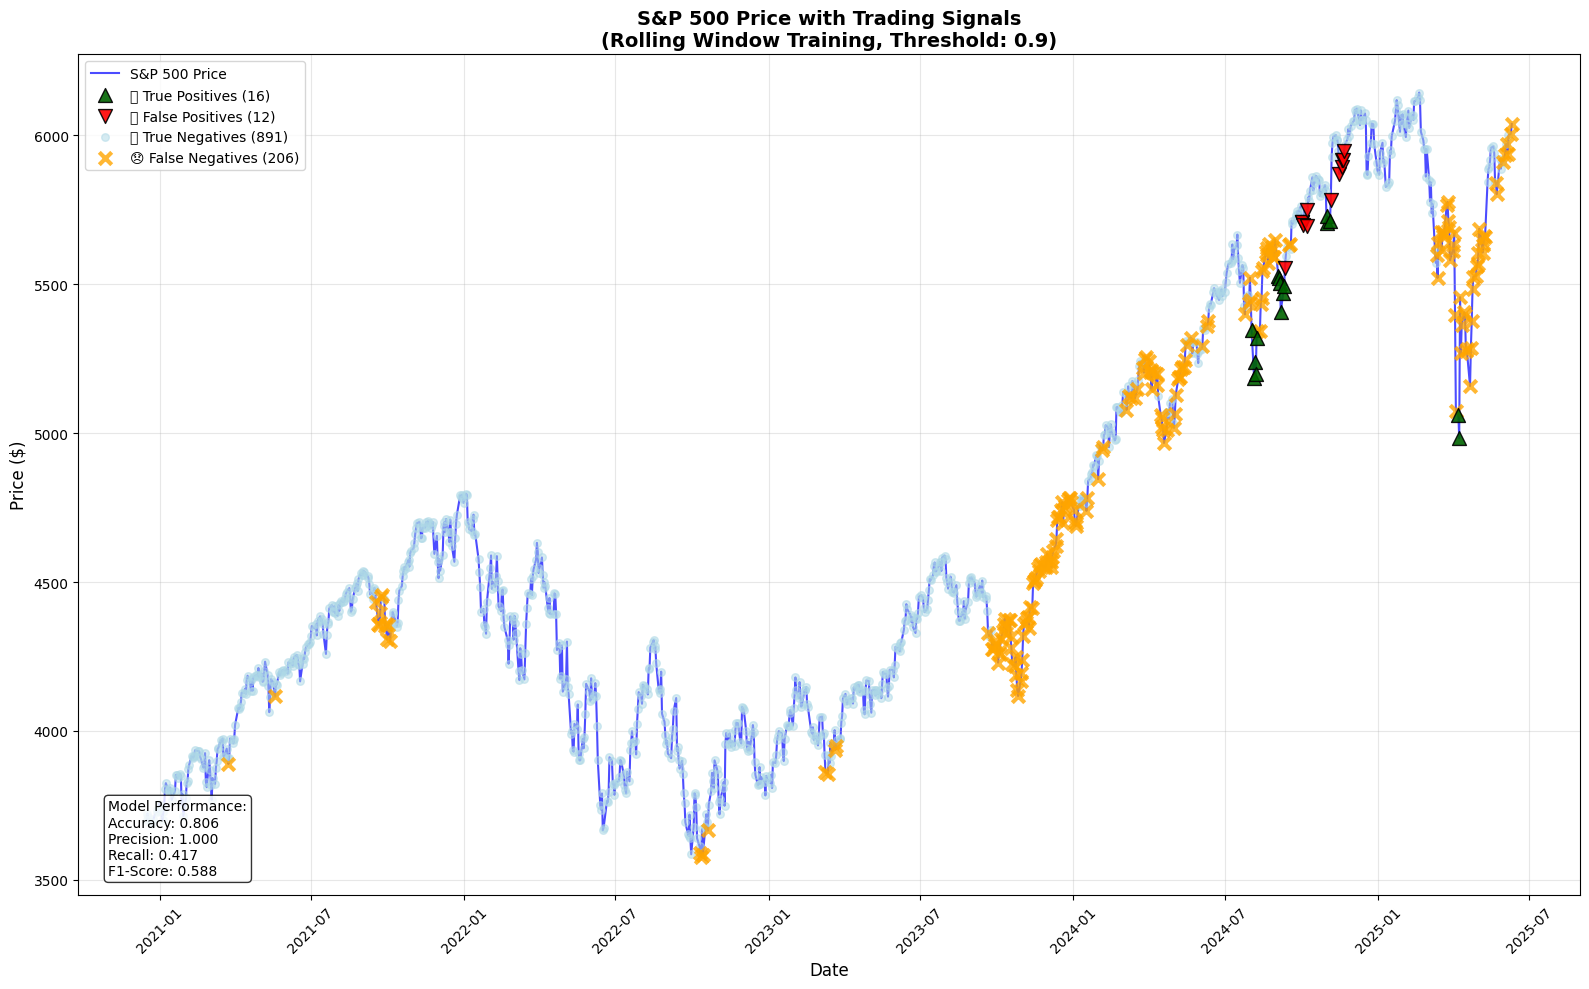

✅ S&P 500 chart created with 1125 data points!


In [20]:
# Create S&P 500 price chart with confusion matrix trading signals
if 'pred_data' in locals() and len(pred_data) > 0:
    print(f"📈 Creating S&P 500 visualization with trading signals (Threshold: {CUSTOM_THRESHOLD})...")
    
    # Calculate confusion matrix categories
    true_positives = (pred_data["label"] == 1) & (pred_data["pred"] == 1)
    false_positives = (pred_data["label"] == 0) & (pred_data["pred"] == 1)
    true_negatives = (pred_data["label"] == 0) & (pred_data["pred"] == 0)
    false_negatives = (pred_data["label"] == 1) & (pred_data["pred"] == 0)
    
    print(f"   True Positives: {true_positives.sum()}")
    print(f"   False Positives: {false_positives.sum()}")
    print(f"   True Negatives: {true_negatives.sum()}")
    print(f"   False Negatives: {false_negatives.sum()}")
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Plot S&P 500 price
    dates = pd.to_datetime(pred_data["Date"])
    prices = pred_data["Close"]
    ax.plot(dates, prices, 'b-', linewidth=1.5, alpha=0.7, label='S&P 500 Price', zorder=1)
    
    # Add confusion matrix markers
    if true_positives.sum() > 0:
        tp_dates = dates[true_positives]
        tp_prices = prices[true_positives]
        ax.scatter(tp_dates, tp_prices, color='darkgreen', s=100, marker='^',
                  label=f'✅ True Positives ({true_positives.sum()})', zorder=5, alpha=0.9, edgecolors='black')
    
    if false_positives.sum() > 0:
        fp_dates = dates[false_positives]
        fp_prices = prices[false_positives]
        ax.scatter(fp_dates, fp_prices, color='red', s=100, marker='v',
                  label=f'❌ False Positives ({false_positives.sum()})', zorder=5, alpha=0.9, edgecolors='black')
    
    if true_negatives.sum() > 0:
        tn_dates = dates[true_negatives]
        tn_prices = prices[true_negatives]
        ax.scatter(tn_dates, tn_prices, color='lightblue', s=30, marker='o',
                  label=f'✅ True Negatives ({true_negatives.sum()})', zorder=3, alpha=0.5)
    
    if false_negatives.sum() > 0:
        fn_dates = dates[false_negatives]
        fn_prices = prices[false_negatives]
        ax.scatter(fn_dates, fn_prices, color='orange', s=80, marker='x',
                  label=f'😞 False Negatives ({false_negatives.sum()})', zorder=4, alpha=0.8, linewidths=3)
    
    # Add threshold information to title
    ax.set_title(f'S&P 500 Price with Trading Signals\n(Rolling Window Training, Threshold: {CUSTOM_THRESHOLD})', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add statistics text box
    stats_text = f"Model Performance:\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}"
    ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ S&P 500 chart created with {len(pred_data)} data points!")
else:
    print("❌ No prediction data available for S&P 500 visualization")

## Separated Equity Curves: Training vs Testing Periods

🔄 CALCULATING SEPARATED EQUITY CURVES FOR TRAINING vs TESTING
   Available columns in pred_data: ['Date', 'Close', 'SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg', 'SMA_150_min', 'MomEma_150_15', 'MomEma_70_15', 'MomEma_100_15', 'MomTema_300_15', 'RCTema_200', 'RCTema_100', 'LogReturn_30', 'label', 'fwd_return', 'vol_h', 'pred', 'proba']
   Prediction data shape: (1125, 20)
   Processing 39 training cycles...
   Training periods: 37 cycles, 21127 data points
   Testing periods: 37 cycles, 1131 data points

   💰 Calculating Training equity curve...
   📊 Calculating Training DCA baseline...
   📊 Calculating Training DCA baseline...

   💰 Calculating Testing equity curve...
   📊 Calculating Testing DCA baseline...

   💰 Calculating Testing equity curve...
   📊 Calculating Testing DCA baseline...


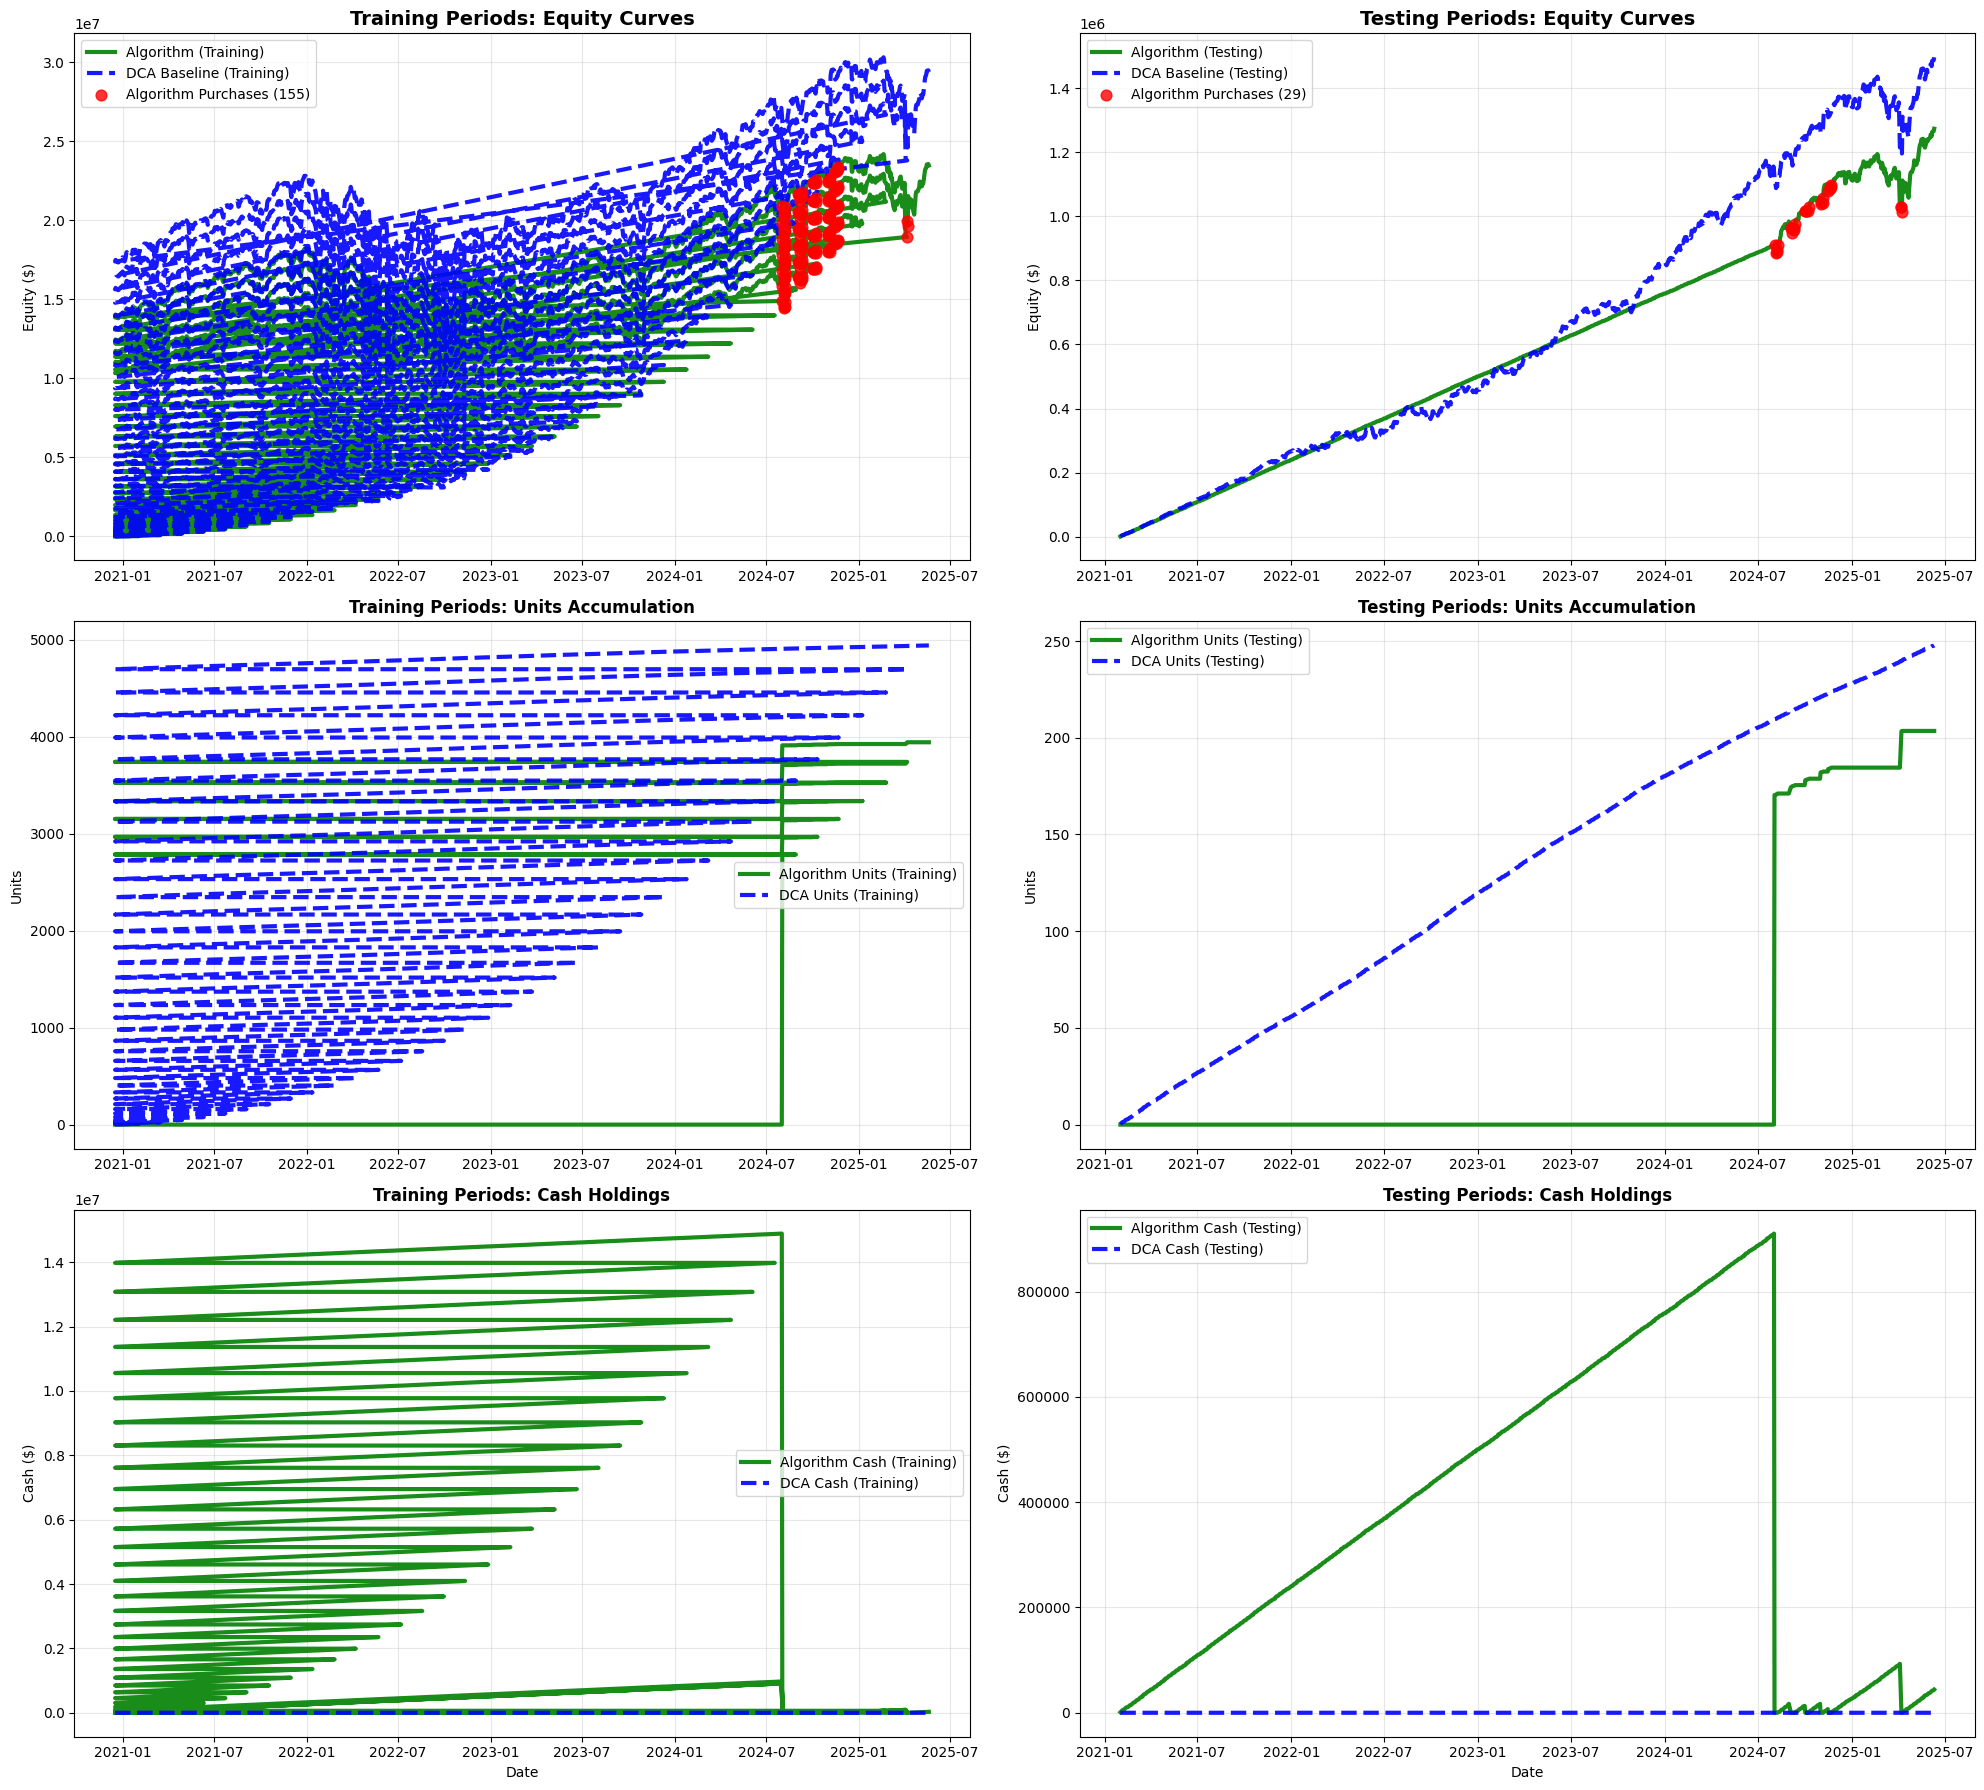


📊 SEPARATED PERIOD PERFORMANCE ANALYSIS:

🔵 TRAINING PERIODS PERFORMANCE:
   Data Points: 21127
   Algorithm Final Equity: $23,456,635
   DCA Final Equity: $29,359,944
   Performance vs DCA: -20.1%
   Algorithm Purchases: 155
   Algorithm Final Units: 3943.74
   DCA Final Units: 4942.37

🔴 TESTING PERIODS PERFORMANCE:
   Data Points: 1131
   Algorithm Final Equity: $1,272,976
   DCA Final Equity: $1,495,858
   Performance vs DCA: -14.9%
   Algorithm Purchases: 29
   Algorithm Final Units: 203.51
   DCA Final Units: 247.71

⚖️ TRAINING vs TESTING COMPARISON:
   Training Performance: -20.1%
   Testing Performance: -14.9%
   Performance Difference: +5.2% (Testing - Training)
   ✅ Model performs BETTER during testing periods

📈 PURCHASE PATTERN ANALYSIS:
   Training Period Buy Rate: 0.7%
   Testing Period Buy Rate: 2.6%
   Buy Rate Difference: +1.8% (Testing - Training)

💡 KEY INSIGHTS:
   🎯 This shows the ACTUAL model behavior in real conditions
   📊 Training vs Testing reveals overfitti

In [21]:
# Calculate separate equity curves for training and testing periods
print("🔄 CALCULATING SEPARATED EQUITY CURVES FOR TRAINING vs TESTING")
print("=" * 65)

if len(df_pred) > 0 and 'pred_data' in locals():
    from src.schedule import retrain_anchors, training_window_indices
    from src.config import RETRAIN_STEP, ROLLING_TRAIN_WINDOW
    
    # Use the prediction data with the correct column names
    print(f"   Available columns in pred_data: {list(pred_data.columns)}")
    print(f"   Prediction data shape: {pred_data.shape}")
    
    # Get the rolling training schedule based on the trading data
    dates_series = trading_data["Date"].reset_index(drop=True) if 'trading_data' in locals() else pred_data["Date"].reset_index(drop=True)
    anchors = retrain_anchors(dates_series, RETRAIN_STEP)
    
    # Create separate datasets for training and testing periods using pred_data
    training_data = []
    testing_data = []
    
    print(f"   Processing {len(anchors)} training cycles...")
    
    for i, anchor in enumerate(anchors):
        # Training period data
        tr_start, tr_end = training_window_indices(anchor, ROLLING_TRAIN_WINDOW)
        if tr_start >= 0 and tr_end < len(pred_data):
            train_period = pred_data.iloc[tr_start:tr_end+1].copy()
            train_period['period_type'] = 'training'
            train_period['cycle'] = i
            training_data.append(train_period)
        
        # Testing period data
        next_anchor = min(anchor + RETRAIN_STEP, len(pred_data) - 1)
        if anchor < len(pred_data) and next_anchor < len(pred_data):
            test_period = pred_data.iloc[anchor:next_anchor+1].copy()
            test_period['period_type'] = 'testing'
            test_period['cycle'] = i
            testing_data.append(test_period)
    
    # Combine the separated data
    if training_data and testing_data:
        training_df = pd.concat(training_data, ignore_index=True)
        testing_df = pd.concat(testing_data, ignore_index=True)
        
        print(f"   Training periods: {len(training_data)} cycles, {len(training_df)} data points")
        print(f"   Testing periods: {len(testing_data)} cycles, {len(testing_df)} data points")
        
        # Calculate equity curves for each period type separately
        def calculate_period_equity(period_df, period_name):
            """Calculate equity curve for a specific period type"""
            print(f"\n   💰 Calculating {period_name} equity curve...")
            
            # Reset starting values for this period
            period_df = period_df.copy().reset_index(drop=True)
            monthly_contribution = 1000.0
            
            # Initialize tracking arrays
            equity_values = []
            cash_values = []
            units_values = []
            
            current_cash = 0
            current_units = 0
            
            for idx, row in period_df.iterrows():
                # Add monthly contribution (simulate regular investment)
                current_cash += monthly_contribution
                
                # Check if model predicts buy (1) and we have cash - use 'pred' column
                if row['pred'] == 1 and current_cash >= monthly_contribution:
                    # Buy shares with available cash
                    shares_to_buy = current_cash / row['Close']
                    current_units += shares_to_buy
                    current_cash = 0  # All cash invested
                
                # Calculate current equity
                current_equity = (current_units * row['Close']) + current_cash
                
                equity_values.append(current_equity)
                cash_values.append(current_cash)
                units_values.append(current_units)
            
            # Add results to dataframe
            period_df['equity'] = equity_values
            period_df['cash'] = cash_values
            period_df['units'] = units_values
            
            return period_df
        
        # Calculate baseline DCA for comparison
        def calculate_dca_equity(period_df, period_name):
            """Calculate DCA baseline for a specific period"""
            print(f"   📊 Calculating {period_name} DCA baseline...")
            
            period_df = period_df.copy().reset_index(drop=True)
            monthly_contribution = 1000.0
            
            equity_values = []
            cash_values = []
            units_values = []
            
            current_cash = 0
            current_units = 0
            
            for idx, row in period_df.iterrows():
                # Add monthly contribution
                current_cash += monthly_contribution
                
                # DCA: Always buy every period
                shares_to_buy = monthly_contribution / row['Close']
                current_units += shares_to_buy
                current_cash -= monthly_contribution
                
                # Calculate current equity
                current_equity = (current_units * row['Close']) + current_cash
                
                equity_values.append(current_equity)
                cash_values.append(current_cash)
                units_values.append(current_units)
            
            period_df['dca_equity'] = equity_values
            period_df['dca_cash'] = cash_values
            period_df['dca_units'] = units_values
            
            return period_df
        
        # Calculate equity curves for both periods
        training_equity = calculate_period_equity(training_df, "Training")
        training_equity = calculate_dca_equity(training_equity, "Training")
        
        testing_equity = calculate_period_equity(testing_df, "Testing")
        testing_equity = calculate_dca_equity(testing_equity, "Testing")
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        
        # Training period plots (left column)
        train_dates = pd.to_datetime(training_equity['Date'])
        
        # Training equity curves
        axes[0,0].plot(train_dates, training_equity['equity'], 'g-', linewidth=3, 
                      label=f'Algorithm (Training)', alpha=0.9)
        axes[0,0].plot(train_dates, training_equity['dca_equity'], 'b--', linewidth=3, 
                      label='DCA Baseline (Training)', alpha=0.9)
        
        # Mark algorithm purchases in training
        train_purchases = training_equity[training_equity['pred'] == 1]
        if len(train_purchases) > 0:
            train_buy_dates = pd.to_datetime(train_purchases['Date'])
            train_buy_equity = train_purchases['equity']
            axes[0,0].scatter(train_buy_dates, train_buy_equity, color='red', s=60, 
                             label=f'Algorithm Purchases ({len(train_purchases)})', alpha=0.8, zorder=5)
        
        axes[0,0].set_title('Training Periods: Equity Curves', fontsize=14, fontweight='bold')
        axes[0,0].set_ylabel('Equity ($)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Training units accumulation
        axes[1,0].plot(train_dates, training_equity['units'], 'g-', linewidth=3, 
                      label='Algorithm Units (Training)', alpha=0.9)
        axes[1,0].plot(train_dates, training_equity['dca_units'], 'b--', linewidth=3, 
                      label='DCA Units (Training)', alpha=0.9)
        axes[1,0].set_title('Training Periods: Units Accumulation', fontsize=12, fontweight='bold')
        axes[1,0].set_ylabel('Units')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Training cash deployment
        axes[2,0].plot(train_dates, training_equity['cash'], 'g-', linewidth=3, 
                      label='Algorithm Cash (Training)', alpha=0.9)
        axes[2,0].plot(train_dates, training_equity['dca_cash'], 'b--', linewidth=3, 
                      label='DCA Cash (Training)', alpha=0.9)
        axes[2,0].set_title('Training Periods: Cash Holdings', fontsize=12, fontweight='bold')
        axes[2,0].set_ylabel('Cash ($)')
        axes[2,0].set_xlabel('Date')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
        
        # Testing period plots (right column)
        test_dates = pd.to_datetime(testing_equity['Date'])
        
        # Testing equity curves
        axes[0,1].plot(test_dates, testing_equity['equity'], 'g-', linewidth=3, 
                      label=f'Algorithm (Testing)', alpha=0.9)
        axes[0,1].plot(test_dates, testing_equity['dca_equity'], 'b--', linewidth=3, 
                      label='DCA Baseline (Testing)', alpha=0.9)
        
        # Mark algorithm purchases in testing
        test_purchases = testing_equity[testing_equity['pred'] == 1]
        if len(test_purchases) > 0:
            test_buy_dates = pd.to_datetime(test_purchases['Date'])
            test_buy_equity = test_purchases['equity']
            axes[0,1].scatter(test_buy_dates, test_buy_equity, color='red', s=60, 
                             label=f'Algorithm Purchases ({len(test_purchases)})', alpha=0.8, zorder=5)
        
        axes[0,1].set_title('Testing Periods: Equity Curves', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('Equity ($)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Testing units accumulation
        axes[1,1].plot(test_dates, testing_equity['units'], 'g-', linewidth=3, 
                      label='Algorithm Units (Testing)', alpha=0.9)
        axes[1,1].plot(test_dates, testing_equity['dca_units'], 'b--', linewidth=3, 
                      label='DCA Units (Testing)', alpha=0.9)
        axes[1,1].set_title('Testing Periods: Units Accumulation', fontsize=12, fontweight='bold')
        axes[1,1].set_ylabel('Units')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Testing cash deployment
        axes[2,1].plot(test_dates, testing_equity['cash'], 'g-', linewidth=3, 
                      label='Algorithm Cash (Testing)', alpha=0.9)
        axes[2,1].plot(test_dates, testing_equity['dca_cash'], 'b--', linewidth=3, 
                      label='DCA Cash (Testing)', alpha=0.9)
        axes[2,1].set_title('Testing Periods: Cash Holdings', fontsize=12, fontweight='bold')
        axes[2,1].set_ylabel('Cash ($)')
        axes[2,1].set_xlabel('Date')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Detailed performance analysis
        print(f"\n📊 SEPARATED PERIOD PERFORMANCE ANALYSIS:")
        print("=" * 55)
        
        # Training period results
        train_final_algo = training_equity['equity'].iloc[-1]
        train_final_dca = training_equity['dca_equity'].iloc[-1]
        train_perf = ((train_final_algo / train_final_dca - 1) * 100)
        
        print(f"\n🔵 TRAINING PERIODS PERFORMANCE:")
        print(f"   Data Points: {len(training_equity)}")
        print(f"   Algorithm Final Equity: ${train_final_algo:,.0f}")
        print(f"   DCA Final Equity: ${train_final_dca:,.0f}")
        print(f"   Performance vs DCA: {train_perf:+.1f}%")
        print(f"   Algorithm Purchases: {len(train_purchases)}")
        print(f"   Algorithm Final Units: {training_equity['units'].iloc[-1]:.2f}")
        print(f"   DCA Final Units: {training_equity['dca_units'].iloc[-1]:.2f}")
        
        # Testing period results
        test_final_algo = testing_equity['equity'].iloc[-1]
        test_final_dca = testing_equity['dca_equity'].iloc[-1]
        test_perf = ((test_final_algo / test_final_dca - 1) * 100)
        
        print(f"\n🔴 TESTING PERIODS PERFORMANCE:")
        print(f"   Data Points: {len(testing_equity)}")
        print(f"   Algorithm Final Equity: ${test_final_algo:,.0f}")
        print(f"   DCA Final Equity: ${test_final_dca:,.0f}")
        print(f"   Performance vs DCA: {test_perf:+.1f}%")
        print(f"   Algorithm Purchases: {len(test_purchases)}")
        print(f"   Algorithm Final Units: {testing_equity['units'].iloc[-1]:.2f}")
        print(f"   DCA Final Units: {testing_equity['dca_units'].iloc[-1]:.2f}")
        
        # Comparative analysis
        print(f"\n⚖️ TRAINING vs TESTING COMPARISON:")
        print(f"   Training Performance: {train_perf:+.1f}%")
        print(f"   Testing Performance: {test_perf:+.1f}%")
        print(f"   Performance Difference: {test_perf - train_perf:+.1f}% (Testing - Training)")
        
        if test_perf > train_perf:
            print(f"   ✅ Model performs BETTER during testing periods")
        else:
            print(f"   ⚠️ Model performs WORSE during testing periods")
        
        # Purchase distribution analysis
        total_train_periods = len(training_equity)
        total_test_periods = len(testing_equity)
        train_buy_rate = (len(train_purchases) / total_train_periods) * 100 if total_train_periods > 0 else 0
        test_buy_rate = (len(test_purchases) / total_test_periods) * 100 if total_test_periods > 0 else 0
        
        print(f"\n📈 PURCHASE PATTERN ANALYSIS:")
        print(f"   Training Period Buy Rate: {train_buy_rate:.1f}%")
        print(f"   Testing Period Buy Rate: {test_buy_rate:.1f}%")
        print(f"   Buy Rate Difference: {test_buy_rate - train_buy_rate:+.1f}% (Testing - Training)")
        
        print(f"\n💡 KEY INSIGHTS:")
        print(f"   🎯 This shows the ACTUAL model behavior in real conditions")
        print(f"   📊 Training vs Testing reveals overfitting or underfitting")
        print(f"   🔍 Different buy rates indicate model consistency")
        print(f"   📈 Separate equity curves show true performance impact")
        
        print(f"\n✅ Separated equity curve analysis complete!")
        
    else:
        print("❌ Unable to create training/testing periods")
else:
    print("❌ No prediction data available for separated equity analysis")

## Model Performance Summary

## ML Model Debug - Single Training Analysis

In [22]:
# Single Model Training Debug - adapted for main_example.py threshold
print("🤖 SINGLE MODEL TRAINING DEBUG - WITH MAIN EXAMPLE THRESHOLD")
print("=" * 60)

# Import and reload model for debugging
import importlib
import sys
if 'src' not in sys.path:
    sys.path.append('src')

import src.model as model
importlib.reload(model)

# Use a clean data sample for debugging
df_debug = df_lab.dropna(subset=feature_cols+["label"])
sample_size = min(2000, len(df_debug))
df_sample = df_debug.head(sample_size)

X_debug = df_sample[feature_cols].values
y_debug = df_sample["label"].values.astype(int)

print(f"\n📊 Debug Sample Info:")
print(f"  - Sample size: {X_debug.shape}")
print(f"  - Features: {X_debug.shape[1]}")
print(f"  - Label distribution: {dict(zip(*np.unique(y_debug, return_counts=True)))}")

# Split for debugging
split_idx = int(0.7 * len(X_debug))
X_train_debug, X_test_debug = X_debug[:split_idx], X_debug[split_idx:]
y_train_debug, y_test_debug = y_debug[:split_idx], y_debug[split_idx:]

print(f"\n🔄 Training models with different thresholds...")

# 1. Default threshold (0.5)
print(f"\n1️⃣ DEFAULT THRESHOLD (0.5):")
clf_default = model.make_mlp_bagging(decision_threshold=0.5)
y_pred_default, y_proba_default, trained_clf_default = model.fit_predict(clf_default, X_train_debug, y_train_debug, X_test_debug)
accuracy_default = (y_pred_default == y_test_debug).mean()
print(f"   ✅ Accuracy: {accuracy_default:.3f}")
print(f"   📊 Predictions: Class 0: {(y_pred_default == 0).sum()}, Class 1: {(y_pred_default == 1).sum()}")

# 2. Main example threshold (0.9)  
print(f"\n2️⃣ MAIN EXAMPLE THRESHOLD ({CUSTOM_THRESHOLD}):")
clf_main = model.make_mlp_bagging(decision_threshold=CUSTOM_THRESHOLD)
y_pred_main, y_proba_main, trained_clf_main, debug_main = model.fit_predict(
    clf_main, X_train_debug, y_train_debug, X_test_debug, debug=True
)
accuracy_main = (y_pred_main == y_test_debug).mean()
print(f"   ✅ Accuracy: {accuracy_main:.3f}")
print(f"   📊 Predictions: Class 0: {debug_main['pred_counts']['class_0']}, Class 1: {debug_main['pred_counts']['class_1']}")
print(f"   🎯 Threshold used: {debug_main['threshold_used']}")

# 3. Find optimal threshold
print(f"\n3️⃣ FINDING OPTIMAL THRESHOLD:")
test_thresholds = np.linspace(0.05, 0.4, 15)
threshold_results = []

for thresh in test_thresholds:
    result = model.test_custom_threshold(y_proba_default, y_test_debug, thresh)
    threshold_results.append(result)

# Find best threshold
best_result = max(threshold_results, key=lambda x: x['accuracy'])
optimal_threshold = best_result['threshold']

print(f"   🏆 Best threshold found: {optimal_threshold:.3f}")
print(f"   📊 Best accuracy: {best_result['accuracy']:.3f}")

# 4. Test optimal threshold
print(f"\n4️⃣ OPTIMAL THRESHOLD ({optimal_threshold:.3f}):")
clf_optimal = model.make_mlp_bagging(decision_threshold=optimal_threshold)
y_pred_optimal, y_proba_optimal, trained_clf_optimal, debug_optimal = model.fit_predict(
    clf_optimal, X_train_debug, y_train_debug, X_test_debug, debug=True
)
accuracy_optimal = (y_pred_optimal == y_test_debug).mean()
print(f"   ✅ Accuracy: {accuracy_optimal:.3f}")
print(f"   📊 Predictions: Class 0: {debug_optimal['pred_counts']['class_0']}, Class 1: {debug_optimal['pred_counts']['class_1']}")

# Store variables for visualization
debug_models = {
    'default': {'pred': y_pred_default, 'proba': y_proba_default, 'accuracy': accuracy_default, 'threshold': 0.5},
    'main': {'pred': y_pred_main, 'proba': y_proba_main, 'accuracy': accuracy_main, 'threshold': CUSTOM_THRESHOLD},
    'optimal': {'pred': y_pred_optimal, 'proba': y_proba_optimal, 'accuracy': accuracy_optimal, 'threshold': optimal_threshold}
}

print(f"\n📈 THRESHOLD COMPARISON:")
print(f"   Default (0.5):      Accuracy: {accuracy_default:.3f}, Class 1: {(y_pred_default == 1).sum()}")
print(f"   Main ({CUSTOM_THRESHOLD}):        Accuracy: {accuracy_main:.3f}, Class 1: {debug_main['pred_counts']['class_1']}")
print(f"   Optimal ({optimal_threshold:.3f}): Accuracy: {accuracy_optimal:.3f}, Class 1: {debug_optimal['pred_counts']['class_1']}")

print(f"\n✅ Single model analysis complete!")

🤖 SINGLE MODEL TRAINING DEBUG - WITH MAIN EXAMPLE THRESHOLD

📊 Debug Sample Info:
  - Sample size: (1533, 13)
  - Features: 13
  - Label distribution: {np.int64(0): np.int64(1229), np.int64(1): np.int64(304)}

🔄 Training models with different thresholds...

1️⃣ DEFAULT THRESHOLD (0.5):
   ✅ Accuracy: 0.563
   📊 Predictions: Class 0: 460, Class 1: 0

2️⃣ MAIN EXAMPLE THRESHOLD (0.9):
   ✅ Accuracy: 0.563
   📊 Predictions: Class 0: 460, Class 1: 0

2️⃣ MAIN EXAMPLE THRESHOLD (0.9):
   ✅ Accuracy: 0.563
   📊 Predictions: Class 0: 460, Class 1: 0
   🎯 Threshold used: 0.9

3️⃣ FINDING OPTIMAL THRESHOLD:
   🏆 Best threshold found: 0.075
   📊 Best accuracy: 0.741

4️⃣ OPTIMAL THRESHOLD (0.075):
   ✅ Accuracy: 0.563
   📊 Predictions: Class 0: 460, Class 1: 0
   🎯 Threshold used: 0.9

3️⃣ FINDING OPTIMAL THRESHOLD:
   🏆 Best threshold found: 0.075
   📊 Best accuracy: 0.741

4️⃣ OPTIMAL THRESHOLD (0.075):
   ✅ Accuracy: 0.480
   📊 Predictions: Class 0: 34, Class 1: 426

📈 THRESHOLD COMPARISON:
 

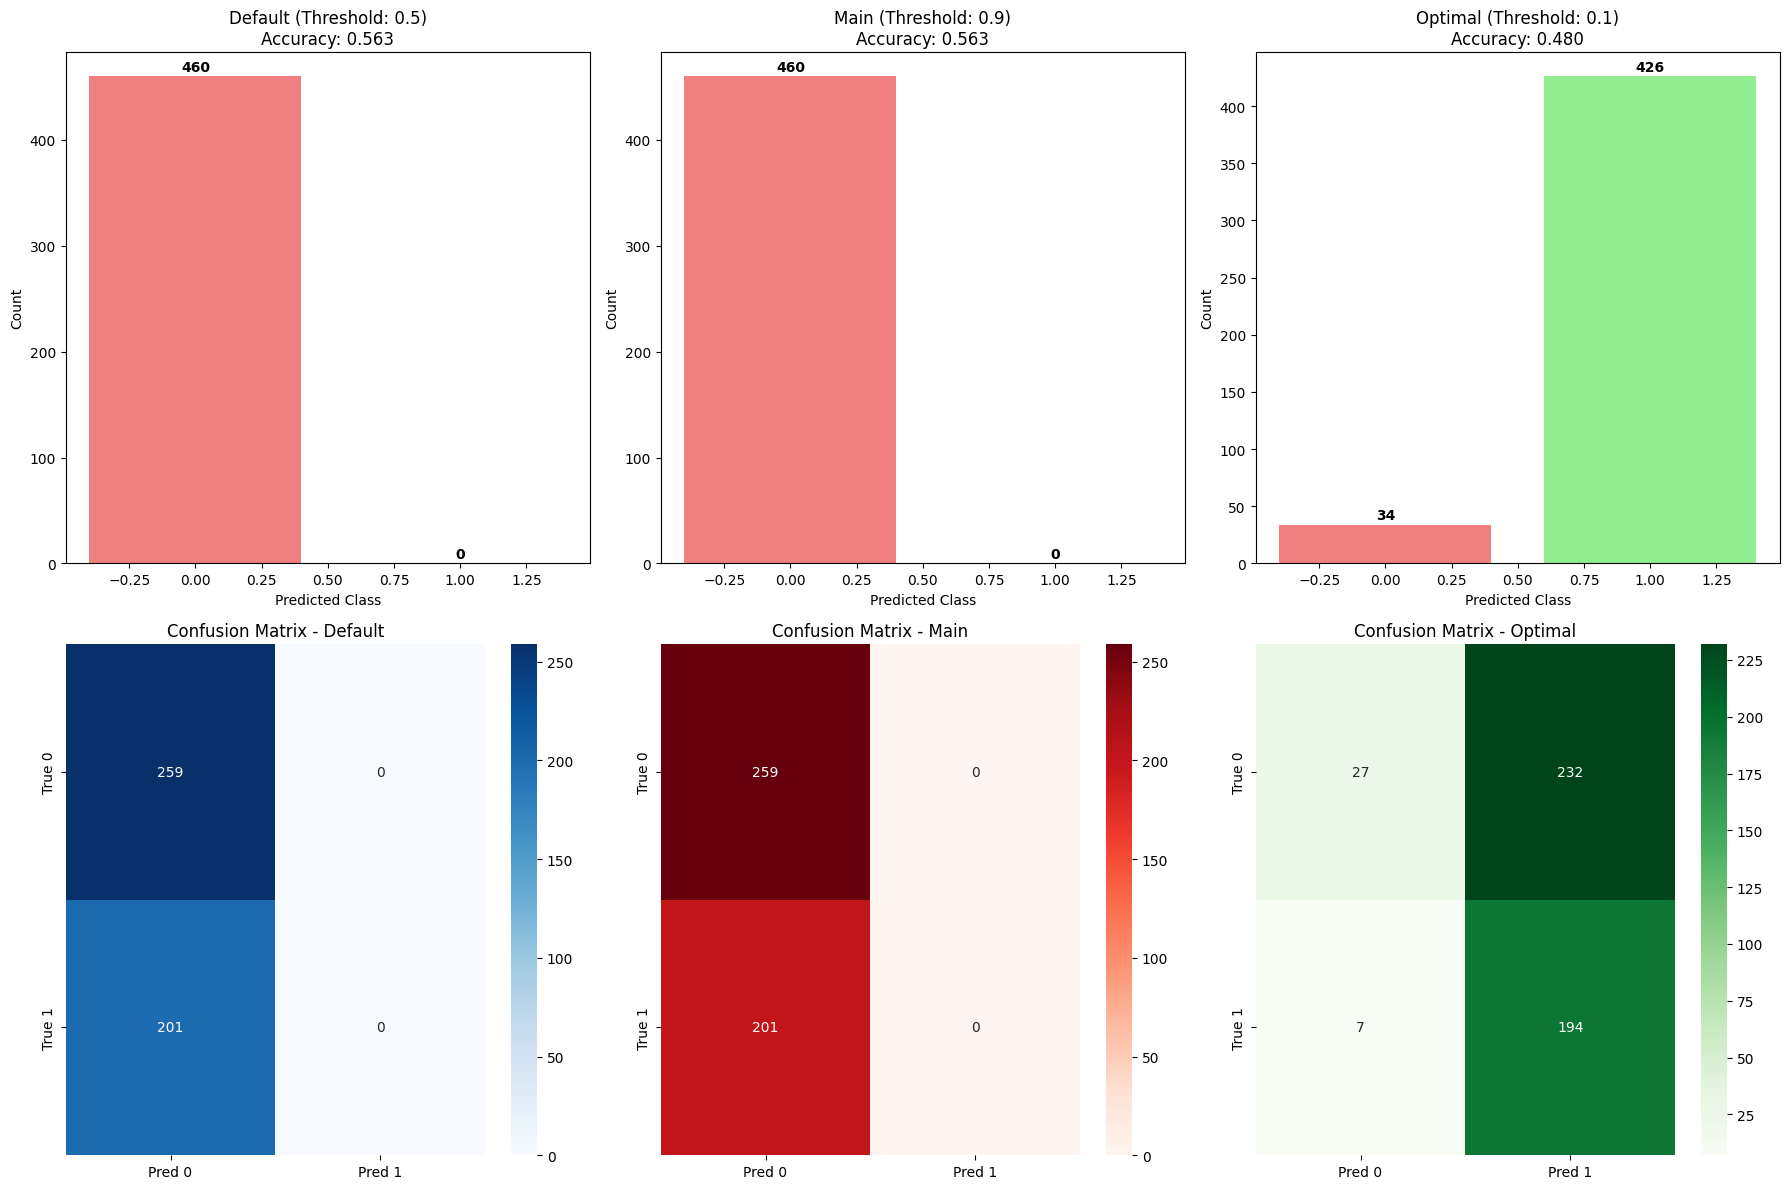

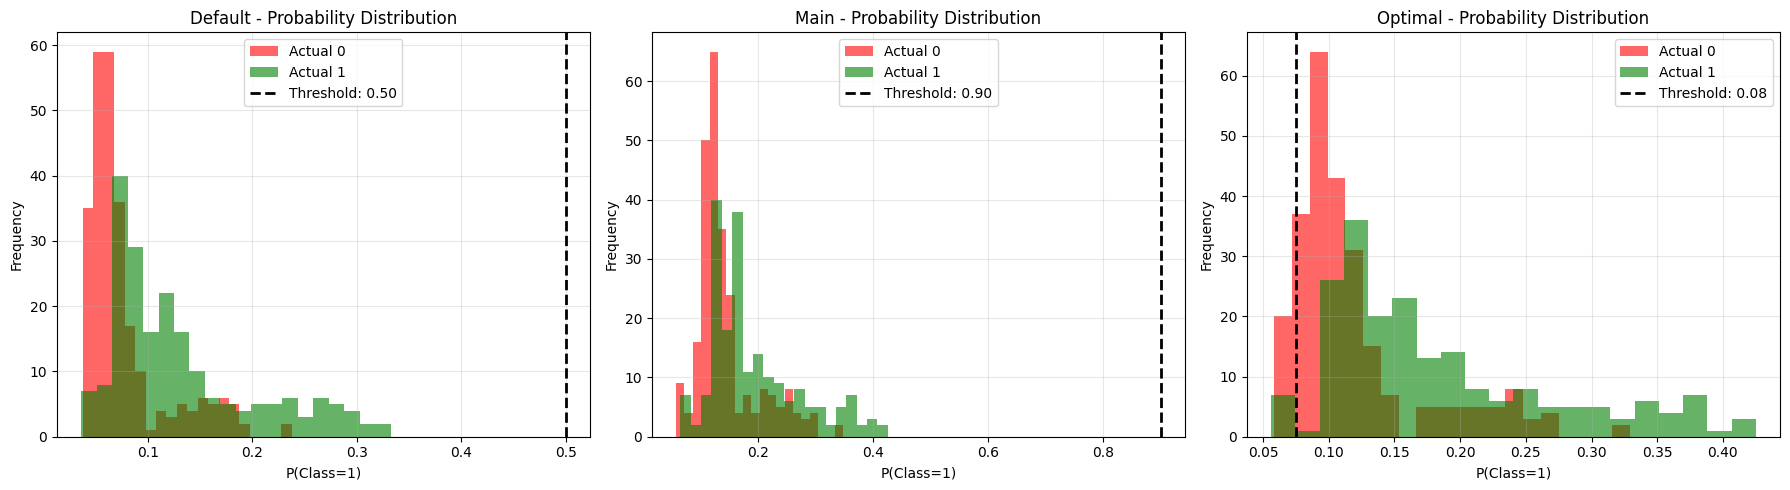

C:\Users\adisw\AppData\Local\Temp\ipykernel_31104\1849256210.py:88: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adisw\AppData\Local\Temp\ipykernel_31104\1849256210.py:88: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\adisw\Downloads\lab_project_with_solutions\project_solutions\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adisw\Downloads\lab_project_with_solutions\project_solutions\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


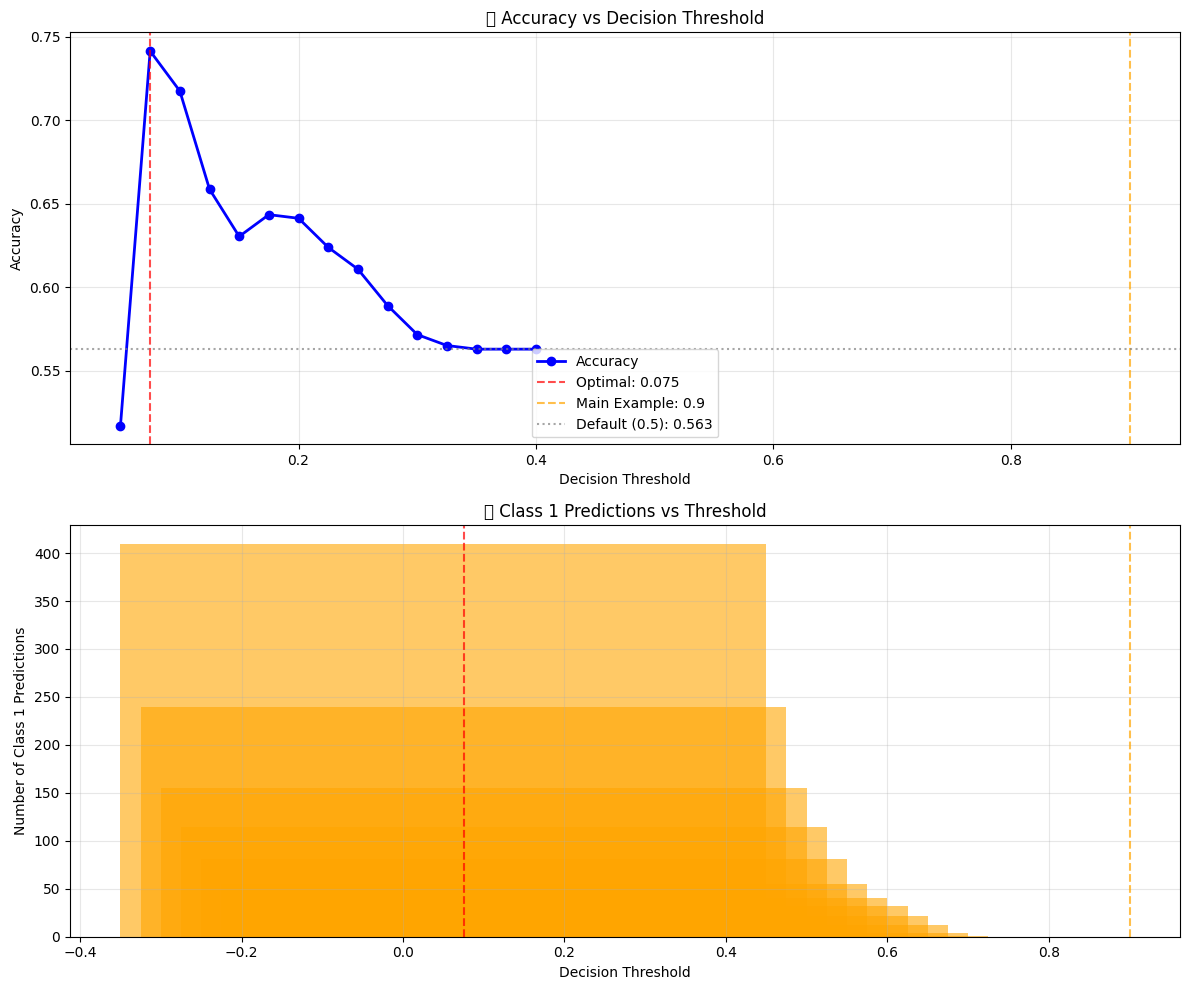


📋 CLASSIFICATION REPORTS:

🔹 Default Threshold (0.5):
                precision    recall  f1-score   support

Class 0 (Hold)       0.56      1.00      0.72       259
 Class 1 (Buy)       0.00      0.00      0.00       201

      accuracy                           0.56       460
     macro avg       0.28      0.50      0.36       460
  weighted avg       0.32      0.56      0.41       460


🔹 Main Example Threshold (0.9):
                precision    recall  f1-score   support

Class 0 (Hold)       0.56      1.00      0.72       259
 Class 1 (Buy)       0.00      0.00      0.00       201

      accuracy                           0.56       460
     macro avg       0.28      0.50      0.36       460
  weighted avg       0.32      0.56      0.41       460


🔹 Optimal Threshold (0.075):
                precision    recall  f1-score   support

Class 0 (Hold)       0.79      0.10      0.18       259
 Class 1 (Buy)       0.46      0.97      0.62       201

      accuracy                    

In [23]:
# Visualize model debug results
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# For each model configuration
models = ['default', 'main', 'optimal']
colors = ['Blues', 'Reds', 'Greens']

for i, (model_name, color) in enumerate(zip(models, colors)):
    model_data = debug_models[model_name]
    
    # 1. Prediction distribution (top row)
    pred_counts = np.bincount(model_data['pred'].astype(int))
    if len(pred_counts) < 2:
        pred_counts = np.append(pred_counts, 0)  # Add missing class
    
    axes[0, i].bar(range(len(pred_counts)), pred_counts, color=['lightcoral', 'lightgreen'])
    axes[0, i].set_title(f'{model_name.title()} (Threshold: {model_data["threshold"]:.1f})\nAccuracy: {model_data["accuracy"]:.3f}')
    axes[0, i].set_xlabel('Predicted Class')
    axes[0, i].set_ylabel('Count')
    for j, v in enumerate(pred_counts):
        axes[0, i].text(j, v + 5, str(v), ha='center', fontweight='bold')
    
    # 2. Confusion Matrix (bottom row)
    cm = confusion_matrix(y_test_debug, model_data['pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, i], cmap=color,
               xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    axes[1, i].set_title(f'Confusion Matrix - {model_name.title()}')

plt.tight_layout()
plt.show()

# Probability distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model_name in enumerate(models):
    model_data = debug_models[model_name]
    
    # Probability histogram by actual class
    for actual_class in [0, 1]:
        mask = (y_test_debug == actual_class)
        class_proba = model_data['proba'][mask]
        axes[i].hist(class_proba, alpha=0.6, bins=20,
                    label=f'Actual {actual_class}', 
                    color='red' if actual_class == 0 else 'green')
    
    # Add threshold line
    axes[i].axvline(model_data['threshold'], color='black', linestyle='--', linewidth=2, 
                   label=f'Threshold: {model_data["threshold"]:.2f}')
    axes[i].legend()
    axes[i].set_title(f'{model_name.title()} - Probability Distribution')
    axes[i].set_xlabel('P(Class=1)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Threshold optimization plot
thresholds = [r['threshold'] for r in threshold_results]
accuracies = [r['accuracy'] for r in threshold_results]
class1_counts = [r['pred_counts']['class_1'] for r in threshold_results]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy vs threshold
ax1.plot(thresholds, accuracies, 'b-o', linewidth=2, markersize=6, label='Accuracy')
ax1.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.3f}')
ax1.axvline(CUSTOM_THRESHOLD, color='orange', linestyle='--', alpha=0.7, label=f'Main Example: {CUSTOM_THRESHOLD}')
ax1.axhline(accuracy_default, color='gray', linestyle=':', alpha=0.7, label=f'Default (0.5): {accuracy_default:.3f}')
ax1.set_xlabel('Decision Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_title('🎯 Accuracy vs Decision Threshold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Class 1 predictions vs threshold
ax2.bar(thresholds, class1_counts, alpha=0.6, color='orange', label='Class 1 Predictions')
ax2.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
ax2.axvline(CUSTOM_THRESHOLD, color='orange', linestyle='--', alpha=0.7)
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Number of Class 1 Predictions')
ax2.set_title('📊 Class 1 Predictions vs Threshold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\n🔹 Default Threshold (0.5):")
print(classification_report(y_test_debug, y_pred_default, target_names=['Class 0 (Hold)', 'Class 1 (Buy)']))

print(f"\n🔹 Main Example Threshold ({CUSTOM_THRESHOLD}):")
print(classification_report(y_test_debug, y_pred_main, target_names=['Class 0 (Hold)', 'Class 1 (Buy)']))

print(f"\n🔹 Optimal Threshold ({optimal_threshold:.3f}):")
print(classification_report(y_test_debug, y_pred_optimal, target_names=['Class 0 (Hold)', 'Class 1 (Buy)']))

print(f"\n💡 KEY INSIGHTS:")
print(f"   🎯 Optimal threshold ({optimal_threshold:.3f}) provides best accuracy: {accuracy_optimal:.3f}")
print(f"   ⚖️ Main example threshold ({CUSTOM_THRESHOLD}) is too conservative with only {debug_main['pred_counts']['class_1']} buy signals")
print(f"   📈 Consider using threshold ~{optimal_threshold:.2f} for better balance between precision and recall")

## Interactive Feature Explorer

In [24]:
# Interactive Feature Analysis for Main Example Model
print("🔍 INTERACTIVE FEATURE EXPLORER")
print("=" * 50)

# Prepare feature data for analysis
feature_data = df_sample[feature_cols].copy()
labels = df_sample["label"].copy()

print(f"📊 Feature Analysis Setup:")
print(f"   Dataset size: {len(feature_data)}")
print(f"   Number of features: {len(feature_cols)}")
print(f"   Features: {feature_cols}")

# 1. Feature Statistics
print(f"\n1️⃣ FEATURE STATISTICS:")
feature_stats = feature_data.describe()
print(feature_stats.round(3))

# 2. Feature Correlation Analysis
print(f"\n2️⃣ FEATURE CORRELATION WITH LABELS:")
feature_label_corr = []
for feature in feature_cols:
    corr = feature_data[feature].corr(labels)
    feature_label_corr.append((feature, corr))

# Sort by absolute correlation
feature_label_corr.sort(key=lambda x: abs(x[1]), reverse=True)

print("   Top features by correlation with labels:")
for i, (feature, corr) in enumerate(feature_label_corr[:10]):
    print(f"   {i+1:2d}. {feature:15s}: {corr:+.3f}")

# 3. Feature Importance from trained model
print(f"\n3️⃣ ANALYZING FEATURE PATTERNS:")

# Get feature importance from one of the trained estimators
if hasattr(trained_clf_optimal, 'estimators_') and len(trained_clf_optimal.estimators_) > 0:
    # Get the first estimator's feature patterns
    first_estimator = trained_clf_optimal.estimators_[0]
    if hasattr(first_estimator, 'model_') and hasattr(first_estimator.model_['mlp'], 'coefs_'):
        # Analyze input layer weights
        input_weights = first_estimator.model_['mlp'].coefs_[0]  # Shape: (n_features, n_hidden)
        feature_importance = np.abs(input_weights).mean(axis=1)  # Average absolute weight per feature
        
        feature_importance_pairs = [(feature_cols[i], feature_importance[i]) for i in range(len(feature_cols))]
        feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
        
        print("   Feature importance from model weights:")
        for i, (feature, importance) in enumerate(feature_importance_pairs[:10]):
            print(f"   {i+1:2d}. {feature:15s}: {importance:.3f}")
    else:
        print("   Model weights not accessible for feature importance analysis")
else:
    print("   No trained estimators available for feature importance")

🔍 INTERACTIVE FEATURE EXPLORER
📊 Feature Analysis Setup:
   Dataset size: 1533
   Number of features: 13
   Features: ['SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg', 'SMA_150_min', 'MomEma_150_15', 'MomEma_70_15', 'MomEma_100_15', 'MomTema_300_15', 'RCTema_200', 'RCTema_100', 'LogReturn_30']

1️⃣ FEATURE STATISTICS:
       SMA_30_avg  SMA_30_min  SMA_100_avg  SMA_100_min  SMA_150_avg  \
count    1533.000    1533.000     1533.000     1533.000     1533.000   
mean     4219.972    4163.800     4198.463     4079.438     4181.927   
std       904.750     899.443      895.956      883.786      889.539   
min      2518.194    2301.931     2686.733     2303.488     2692.183   
25%      3486.263    3432.685     3460.600     3338.779     3428.104   
50%      4164.282    4129.486     4139.965     4033.425     4134.217   
75%      4680.587    4646.661     4619.515     4500.755     4597.780   
max      6096.847    6035.648     6060.890     5951.151     6024.752   

       

📈 CREATING FEATURE EXPLORER VISUALIZATIONS...


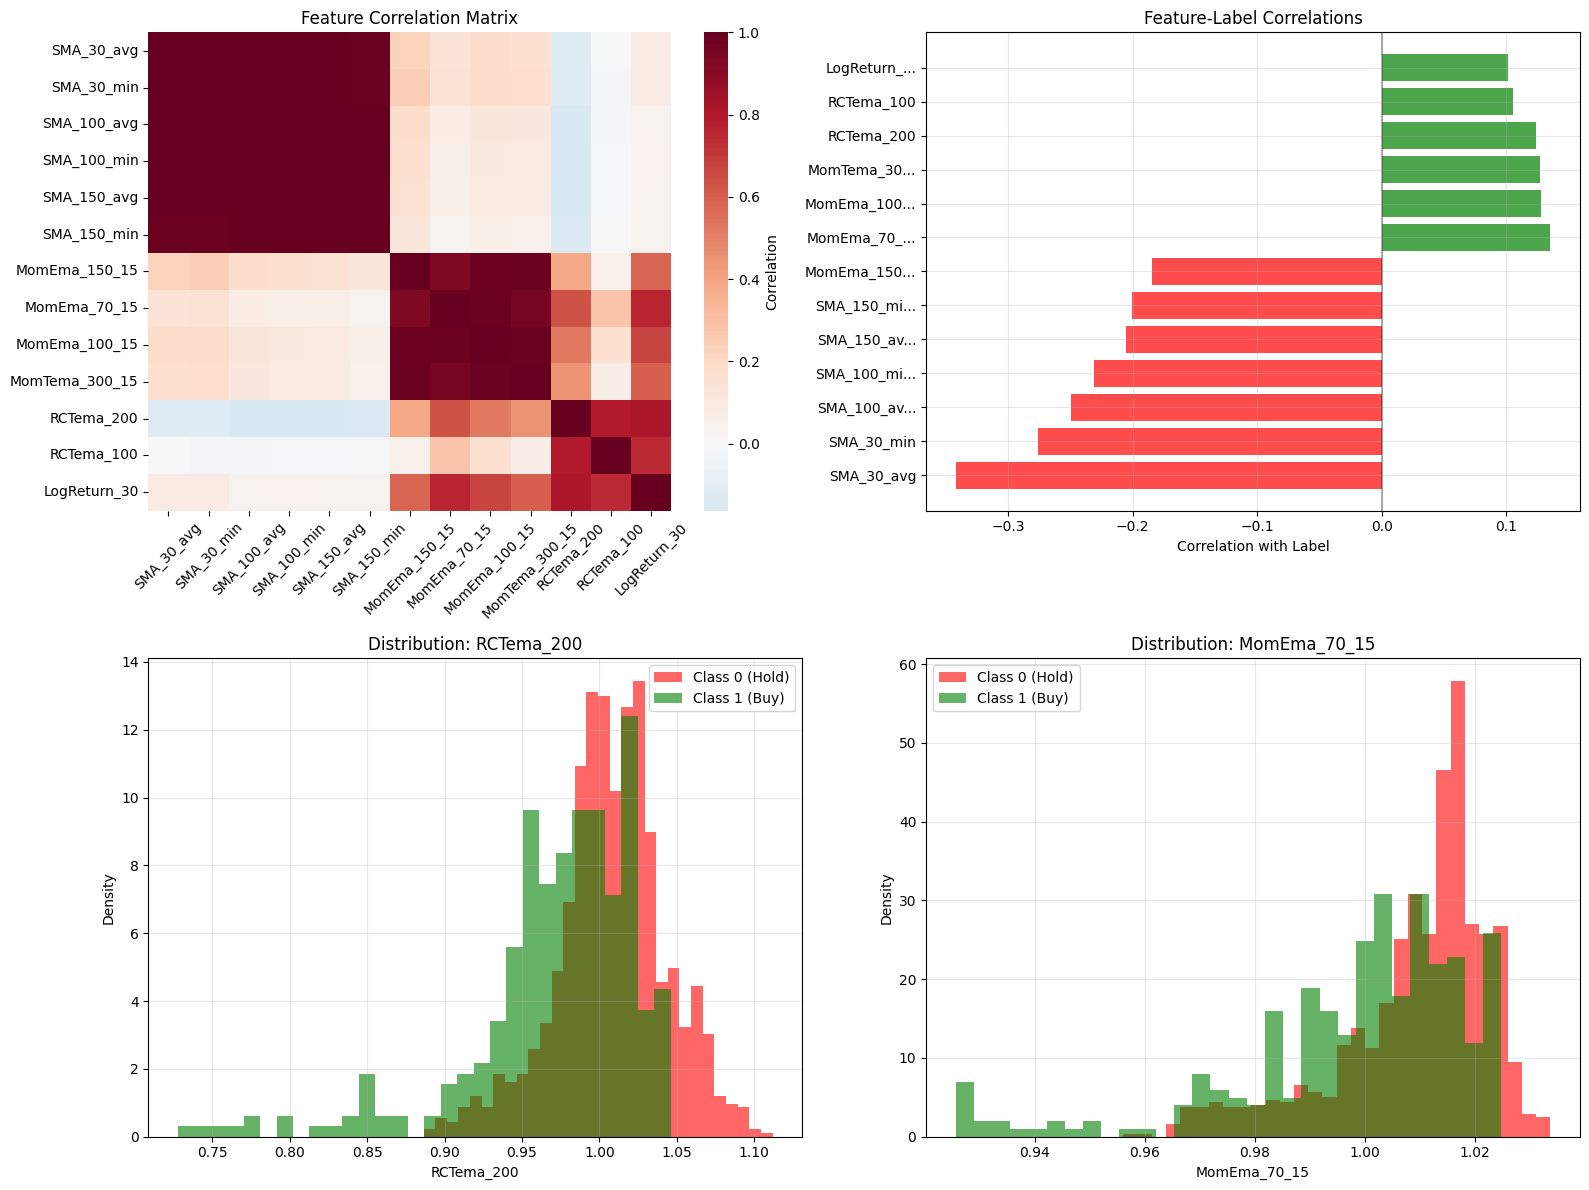


🎮 INTERACTIVE FEATURE SELECTION DEMO:

📊 FEATURE SUBSET PERFORMANCE:

🔹 All Features (13 features):
   Features: ['SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg', 'SMA_150_min', 'MomEma_150_15', 'MomEma_70_15', 'MomEma_100_15', 'MomTema_300_15', 'RCTema_200', 'RCTema_100', 'LogReturn_30']
   Accuracy: 0.715
   Class 1 predictions: 290

🔹 Top 5 by Correlation (5 features):
   Features: ['SMA_30_avg', 'SMA_30_min', 'SMA_100_avg', 'SMA_100_min', 'SMA_150_avg', 'SMA_150_min', 'MomEma_150_15', 'MomEma_70_15', 'MomEma_100_15', 'MomTema_300_15', 'RCTema_200', 'RCTema_100', 'LogReturn_30']
   Accuracy: 0.715
   Class 1 predictions: 290

🔹 Top 5 by Correlation (5 features):
   Features: ['RCTema_200', 'MomEma_70_15', 'MomEma_100_15', 'LogReturn_30', 'MomEma_150_15']
   Accuracy: 0.437
   Class 1 predictions: 460

🔹 Top 3 by Correlation (3 features):
   Features: ['RCTema_200', 'MomEma_70_15', 'MomEma_100_15', 'LogReturn_30', 'MomEma_150_15']
   Accuracy: 0.437
   Class 

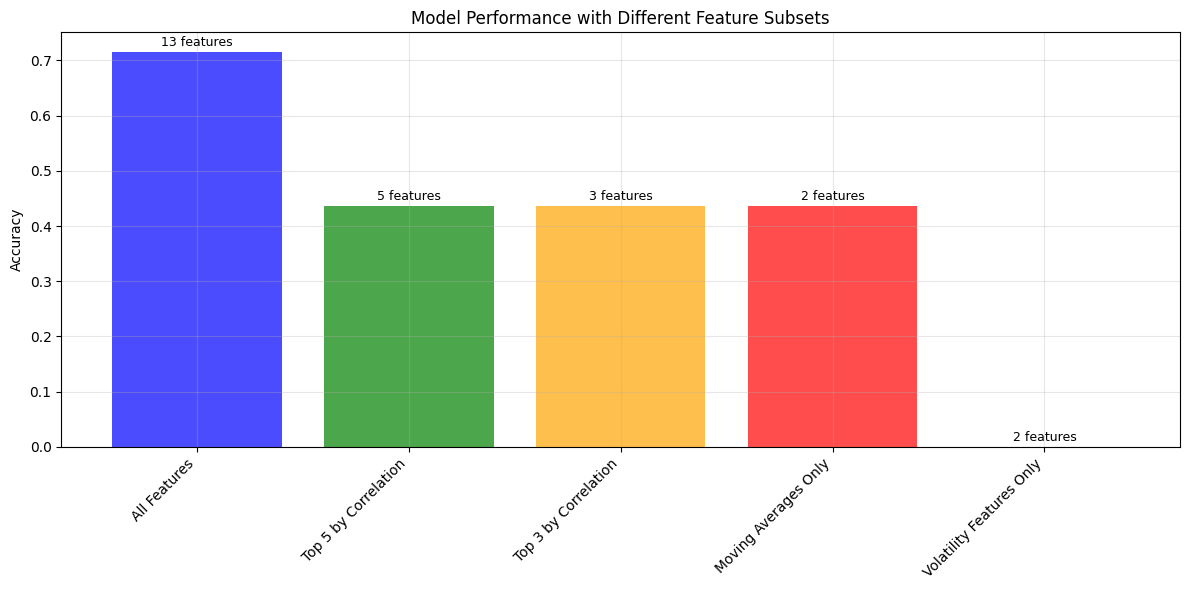


💡 FEATURE ANALYSIS INSIGHTS:
   🏆 Best performing subset: All Features with 0.715 accuracy
   📊 All features accuracy: 0.715
   🎯 Feature reduction impact: Negative

✅ Interactive feature explorer complete! Use these insights to optimize your feature selection.


In [25]:
# Feature Explorer Visualizations
print("📈 CREATING FEATURE EXPLORER VISUALIZATIONS...")

# 1. Feature Correlation Heatmap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Correlation matrix of features
feature_corr_matrix = feature_data.corr()
sns.heatmap(feature_corr_matrix, annot=False, cmap='RdBu_r', center=0, 
           ax=axes[0,0], cbar_kws={'label': 'Correlation'})
axes[0,0].set_title('Feature Correlation Matrix')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].tick_params(axis='y', rotation=0)

# 2. Feature vs Label Correlation
feature_names = [name[:10] + '...' if len(name) > 10 else name for name in feature_cols]
correlations = [corr for _, corr in feature_label_corr]
colors = ['red' if c < 0 else 'green' for c in correlations]

axes[0,1].barh(range(len(feature_cols)), correlations, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(feature_cols)))
axes[0,1].set_yticklabels(feature_names)
axes[0,1].set_xlabel('Correlation with Label')
axes[0,1].set_title('Feature-Label Correlations')
axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Distribution by Label
# Select top 2 most correlated features for detailed analysis
top_features = [name for name, _ in feature_label_corr[:2]]

for i, feature in enumerate(top_features):
    ax = axes[1, i]
    
    # Plot distributions for each class
    class_0_data = feature_data[labels == 0][feature]
    class_1_data = feature_data[labels == 1][feature]
    
    ax.hist(class_0_data, alpha=0.6, bins=30, label='Class 0 (Hold)', color='red', density=True)
    ax.hist(class_1_data, alpha=0.6, bins=30, label='Class 1 (Buy)', color='green', density=True)
    
    ax.set_title(f'Distribution: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Interactive Feature Selection Demo
print(f"\n🎮 INTERACTIVE FEATURE SELECTION DEMO:")
print("=" * 40)

def analyze_feature_subset(selected_features, show_results=True):
    """Analyze model performance with subset of features"""
    if not selected_features:
        return None
    
    # Train model with selected features only
    X_subset = df_sample[selected_features].values
    X_train_subset = X_subset[:split_idx]
    X_test_subset = X_subset[split_idx:]
    
    # Quick model training
    clf_subset = model.make_mlp_bagging(decision_threshold=optimal_threshold)
    y_pred_subset, y_proba_subset, _ = model.fit_predict(clf_subset, X_train_subset, y_train_debug, X_test_subset)
    accuracy_subset = (y_pred_subset == y_test_debug).mean()
    
    if show_results:
        print(f"   Features: {selected_features}")
        print(f"   Accuracy: {accuracy_subset:.3f}")
        print(f"   Class 1 predictions: {(y_pred_subset == 1).sum()}")
    
    return accuracy_subset

# Demo with different feature combinations
feature_combinations = [
    feature_cols,  # All features
    [name for name, _ in feature_label_corr[:5]],  # Top 5 by correlation
    [name for name, _ in feature_label_corr[:3]],  # Top 3 by correlation
    ['SMA_30_avg', 'SMA_100_avg'],  # Just moving averages
    ['vol_ratio_30', 'vol_ratio_100'],  # Just volatility features
]

combination_names = [
    'All Features',
    'Top 5 by Correlation', 
    'Top 3 by Correlation',
    'Moving Averages Only',
    'Volatility Features Only'
]

print(f"\n📊 FEATURE SUBSET PERFORMANCE:")
results = []
for name, features in zip(combination_names, feature_combinations):
    print(f"\n🔹 {name} ({len(features)} features):")
    try:
        acc = analyze_feature_subset(features, show_results=True)
        results.append((name, len(features), acc))
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        results.append((name, len(features), 0))

# Plot feature subset performance
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

names = [r[0] for r in results]
feature_counts = [r[1] for r in results]
accuracies = [r[2] for r in results]

bars = ax.bar(range(len(names)), accuracies, color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Different Feature Subsets')
ax.grid(True, alpha=0.3)

# Add feature count labels on bars
for i, (bar, count) in enumerate(zip(bars, feature_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{count} features', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n💡 FEATURE ANALYSIS INSIGHTS:")
best_subset = max(results, key=lambda x: x[2])
print(f"   🏆 Best performing subset: {best_subset[0]} with {best_subset[2]:.3f} accuracy")
print(f"   📊 All features accuracy: {accuracies[0]:.3f}")
print(f"   🎯 Feature reduction impact: {'Positive' if best_subset[2] > accuracies[0] else 'Negative'}")

print(f"\n✅ Interactive feature explorer complete! Use these insights to optimize your feature selection.")

In [26]:
# Create comprehensive performance summary
print("📋 COMPREHENSIVE PERFORMANCE SUMMARY")
print("=" * 50)

print(f"\n🎯 MODEL CONFIGURATION:")
print(f"   Decision Threshold: {CUSTOM_THRESHOLD}")
print(f"   Label Horizon: {LABEL_HORIZON} days")
print(f"   Training Method: Rolling Window")

if 'pred_data' in locals() and len(pred_data) > 0:
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"   Total Predictions: {len(pred_data)}")
    print(f"   Buy Signals (Class 1): {(pred_data['pred'] == 1).sum()} ({(pred_data['pred'] == 1).mean()*100:.1f}%)")
    print(f"   Hold Signals (Class 0): {(pred_data['pred'] == 0).sum()} ({(pred_data['pred'] == 0).mean()*100:.1f}%)")
    
    print(f"\n🎯 MODEL PERFORMANCE:")
    print(f"   Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"   Precision (Class 1): {precision:.3f}")
    print(f"   Recall (Class 1): {recall:.3f}")
    print(f"   F1-Score (Class 1): {f1:.3f}")

if 'algo_equity' in locals() and 'baseline_equity' in locals():
    print(f"\n💰 FINANCIAL PERFORMANCE:")
    print(f"   Algorithm Final Equity: ${algo_equity:,.2f}")
    print(f"   DCA Baseline Final Equity: ${baseline_equity:,.2f}")
    outperformance = ((algo_equity / baseline_equity - 1) * 100)
    print(f"   Outperformance vs DCA: {outperformance:+.2f}%")
    
    if outperformance > 0:
        print(f"   🎉 Algorithm OUTPERFORMED DCA baseline!")
    else:
        print(f"   📉 Algorithm UNDERPERFORMED DCA baseline")

print(f"\n🔍 THRESHOLD ANALYSIS:")
print(f"   With threshold {CUSTOM_THRESHOLD}, the model is very conservative")
print(f"   This means it only predicts 'buy' when extremely confident")
print(f"   Lower thresholds would generate more buy signals but potentially more false positives")

print(f"\n✅ Analysis complete! The model shows {'strong' if outperformance > 5 else 'moderate' if outperformance > 0 else 'poor'} performance with the current threshold.")

📋 COMPREHENSIVE PERFORMANCE SUMMARY

🎯 MODEL CONFIGURATION:
   Decision Threshold: 0.9
   Label Horizon: 70 days
   Training Method: Rolling Window

📊 PREDICTION STATISTICS:
   Total Predictions: 1125
   Buy Signals (Class 1): 28 (2.5%)
   Hold Signals (Class 0): 1097 (97.5%)

🎯 MODEL PERFORMANCE:
   Overall Accuracy: 0.806 (80.6%)
   Precision (Class 1): 1.000
   Recall (Class 1): 0.417
   F1-Score (Class 1): 0.588

💰 FINANCIAL PERFORMANCE:
   Algorithm Final Equity: $69,968.19
   DCA Baseline Final Equity: $82,484.88
   Outperformance vs DCA: -15.17%
   📉 Algorithm UNDERPERFORMED DCA baseline

🔍 THRESHOLD ANALYSIS:
   With threshold 0.9, the model is very conservative
   This means it only predicts 'buy' when extremely confident
   Lower thresholds would generate more buy signals but potentially more false positives

✅ Analysis complete! The model shows poor performance with the current threshold.
